# Importing Modules

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import datetime
from matplotlib.gridspec import GridSpec
from scipy import stats as ss

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

# Functions

In [2]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

# Loading Data

In [3]:
df_sales_raw = pd.read_csv('train.csv',low_memory=False)
df_store_raw = pd.read_csv('store.csv',low_memory=False)

# Merge
df = pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')

# Data Description

## Rename Columns

In [4]:
df.columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df.columns = cols_new


## Treating NA Values

In [5]:
df['date'] = pd.to_datetime(df['date'])
df.isna().sum()

## Filling NA

df['competition_distance'].max()
df['competition_distance'] = df['competition_distance'].fillna(200000)

df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

df['competition_open_since_year'] = df['competition_open_since_year'].fillna(df['date'].dt.year)
             
df['promo2_since_week'] = df['promo2_since_week'].fillna(df['date'].dt.isocalendar().week)

df['promo2_since_year'] = df['promo2_since_year'].fillna(df['date'].dt.year)
                 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
df['promo_interval'].fillna(0, inplace=True)
df['month_map'] = df['date'].dt.month.map(month_map)
df['is_promo'] = df[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## Change Types

In [6]:
df.dtypes
df['competition_open_since_month'] = df['competition_open_since_month'].astype(int)
df['competition_open_since_year'] = df['competition_open_since_year'].astype(int)
df['promo2_since_week'] = df['promo2_since_week'].astype(int)
df['promo2_since_year'] = df['promo2_since_year'].astype(int)

## Descriptive Statistical

<AxesSubplot:xlabel='sales', ylabel='Count'>

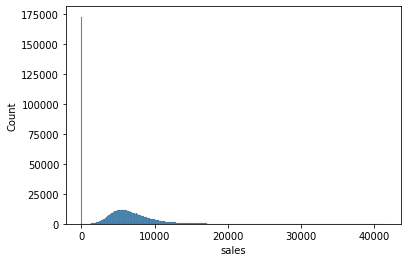

In [7]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

d1 = num_attributes.describe().T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()))
d2.columns = ['skew']
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()))
d3.columns = ['kurtosis']
num_attributes_describe = pd.concat([d1,d2,d3],axis=1).reset_index()

sns.histplot(df['sales'])

In [8]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

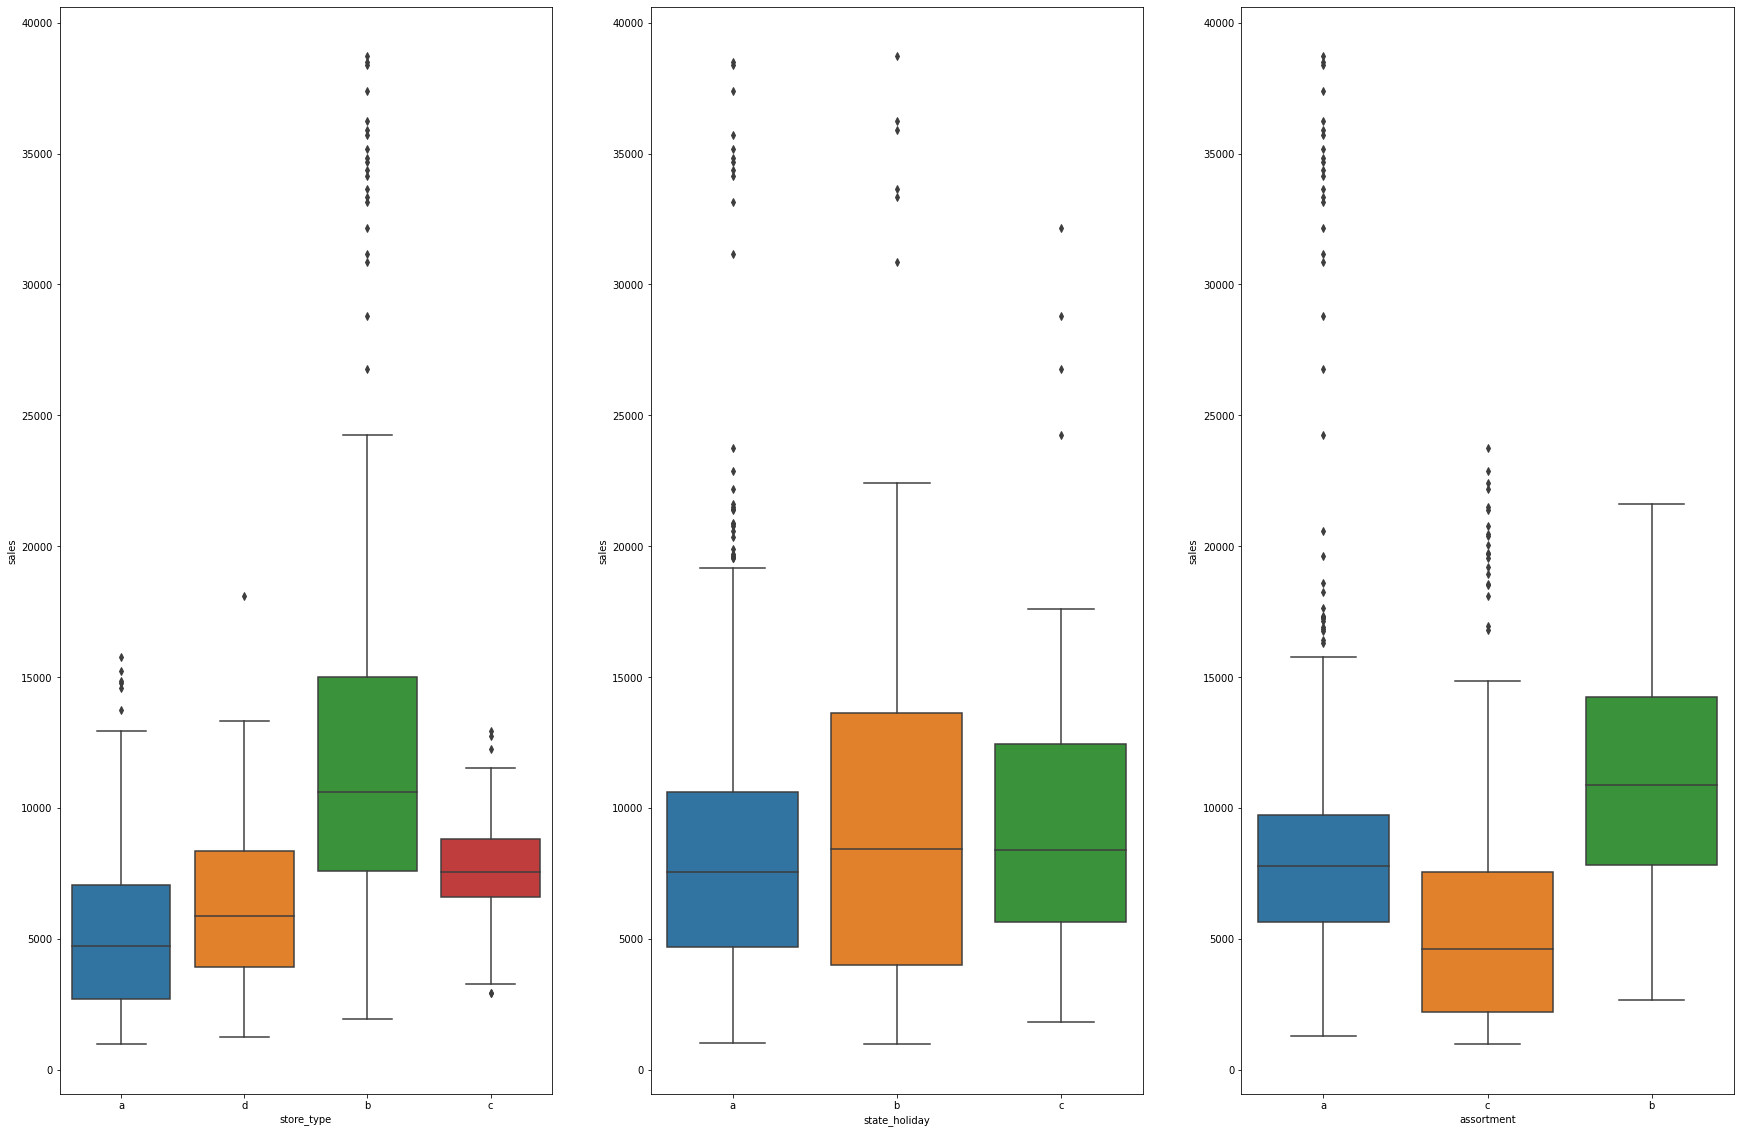

In [9]:
plt.rcParams['figure.figsize'] = [30, 20]
aux = df[(df['state_holiday'] != '0') & (df['sales'] > 0)]
plt.subplot(1,3,1)
sns.boxplot(x='store_type',y='sales',data=aux)            
plt.subplot(1,3,2)
sns.boxplot(x='state_holiday',y='sales',data=aux) 
plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux)

# Feature Engineering

## Hypothesis List

**1.** Store with more assortment should have higher sales.

**2.** Store closer to the competitor should have lower sales 

**3.** Store with competitors for longer should have higher sales

**4.** Stores with longer activated promotions should have higher sales. 
    
**5.** Stores with more days in promotion should have higher sales.
    
**6.** Stores with more consecutives promotions should have higher sales.

**7.** Stores open during Christmas period should have higher sales.

**8.** Stores should increase their sales year by year

**9.** Stores should have higher sales on the second half of the year

**10.** Stores should have higher sales after the 10th of each month 

**11.** Stores should have lower sales on weekends

**12.** Stores should have lower sales on school holidays

In [10]:
df2=df.copy()

## Feature Engineering

In [11]:
# year
df2['year']=df2['date'].dt.year
# month
df2['month']=df2['date'].dt.month
# day
df2['day']=df2['date'].dt.day
# week of year
df2['week_of_year']=df2['date'].dt.week
# year week
df2['year_week']=df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x:x.days).astype(int)

# assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extend')

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')


<ipython-input-11-2d02db7cae96>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year']=df2['date'].dt.week


In [12]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# Variables Filtering

In [13]:
df3 = df2.copy()

In [14]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# Exploratory Data Analysis

In [15]:
df4 = df3.copy()

## Response Variable

/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

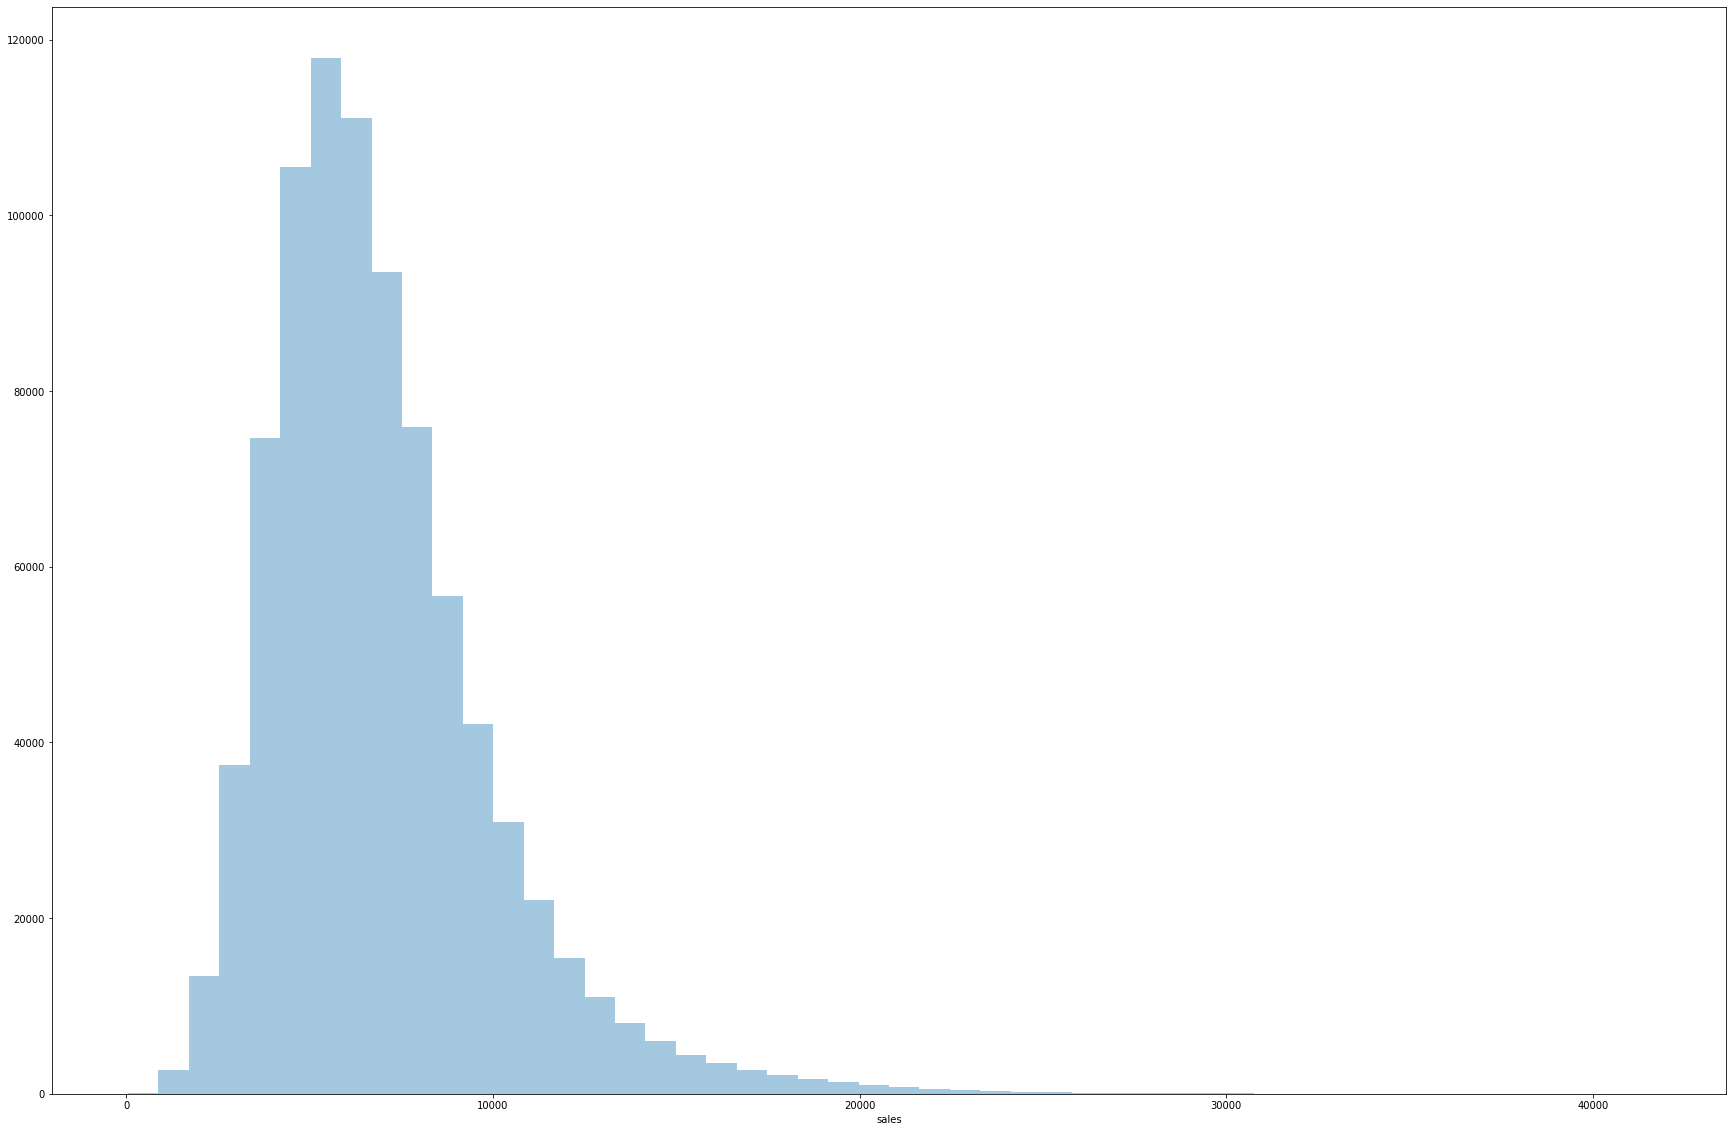

In [16]:
sns.distplot(df4['sales'],kde=False)

## Numerical Variable

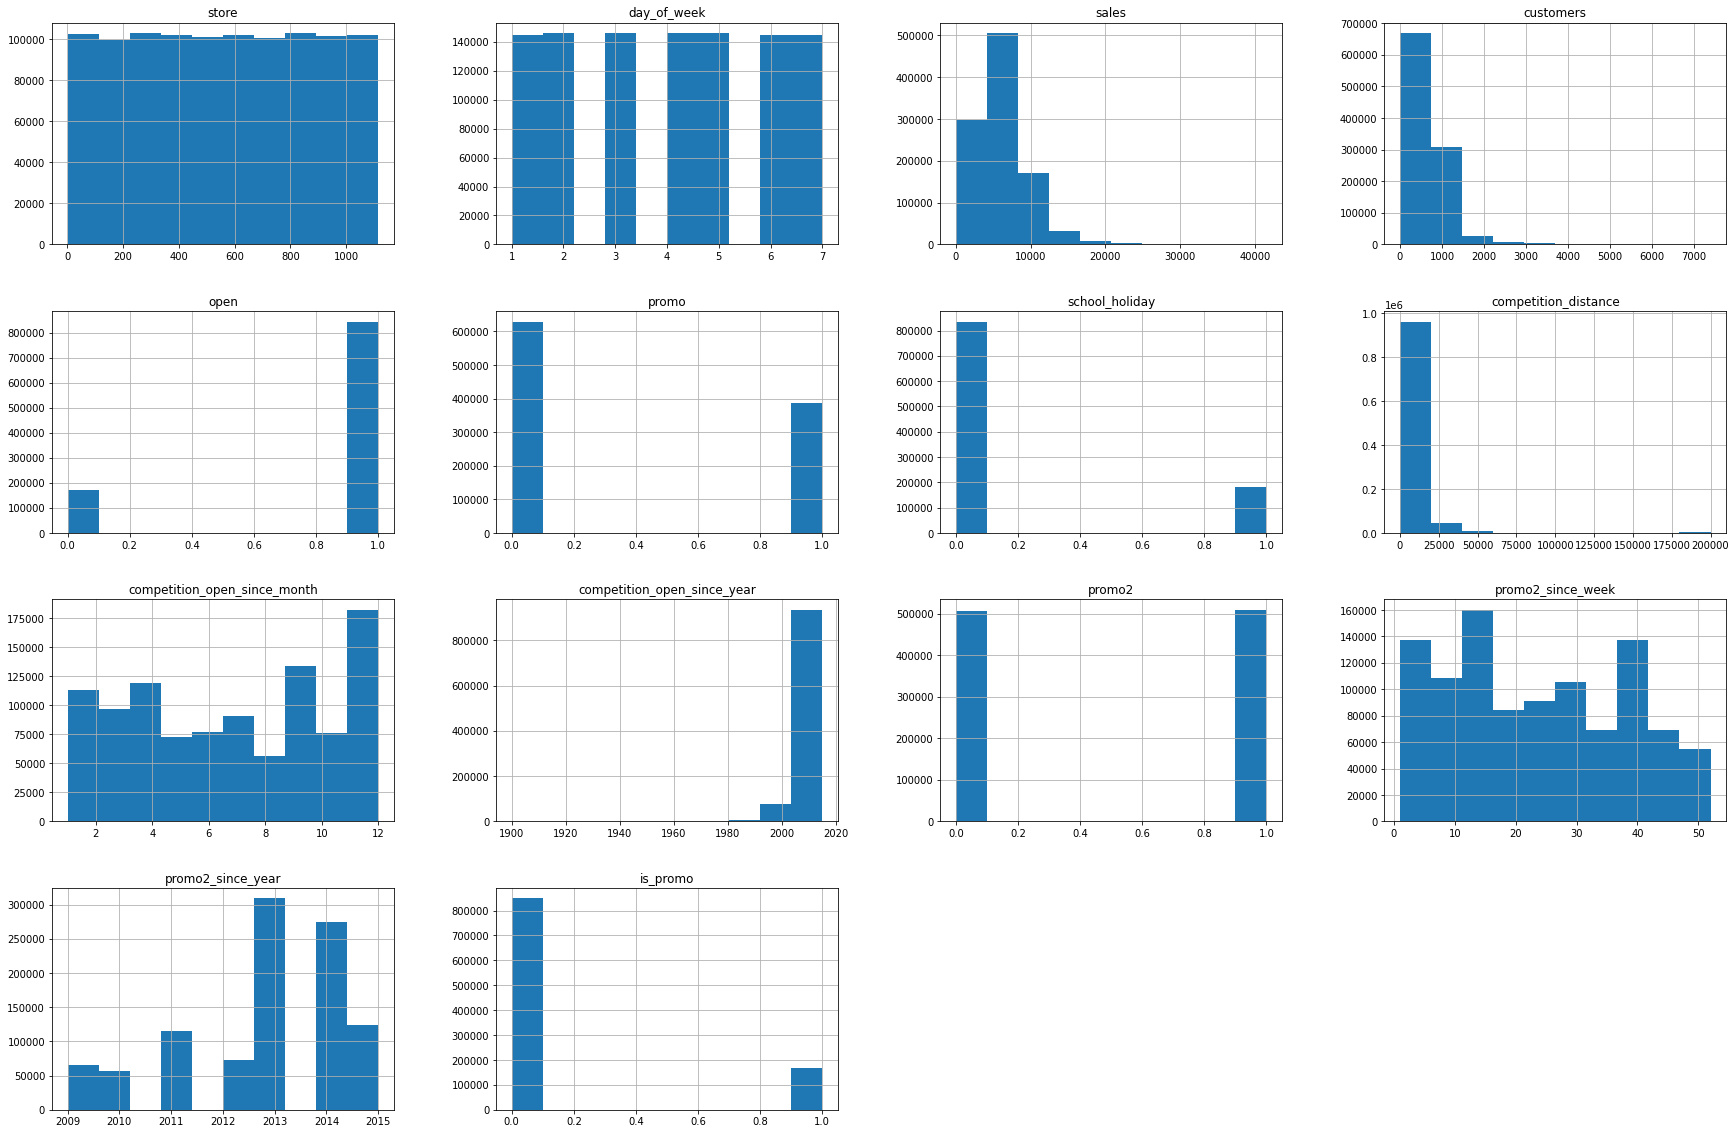

In [17]:
num_attributes.hist();

## Categorical Variable

In [18]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

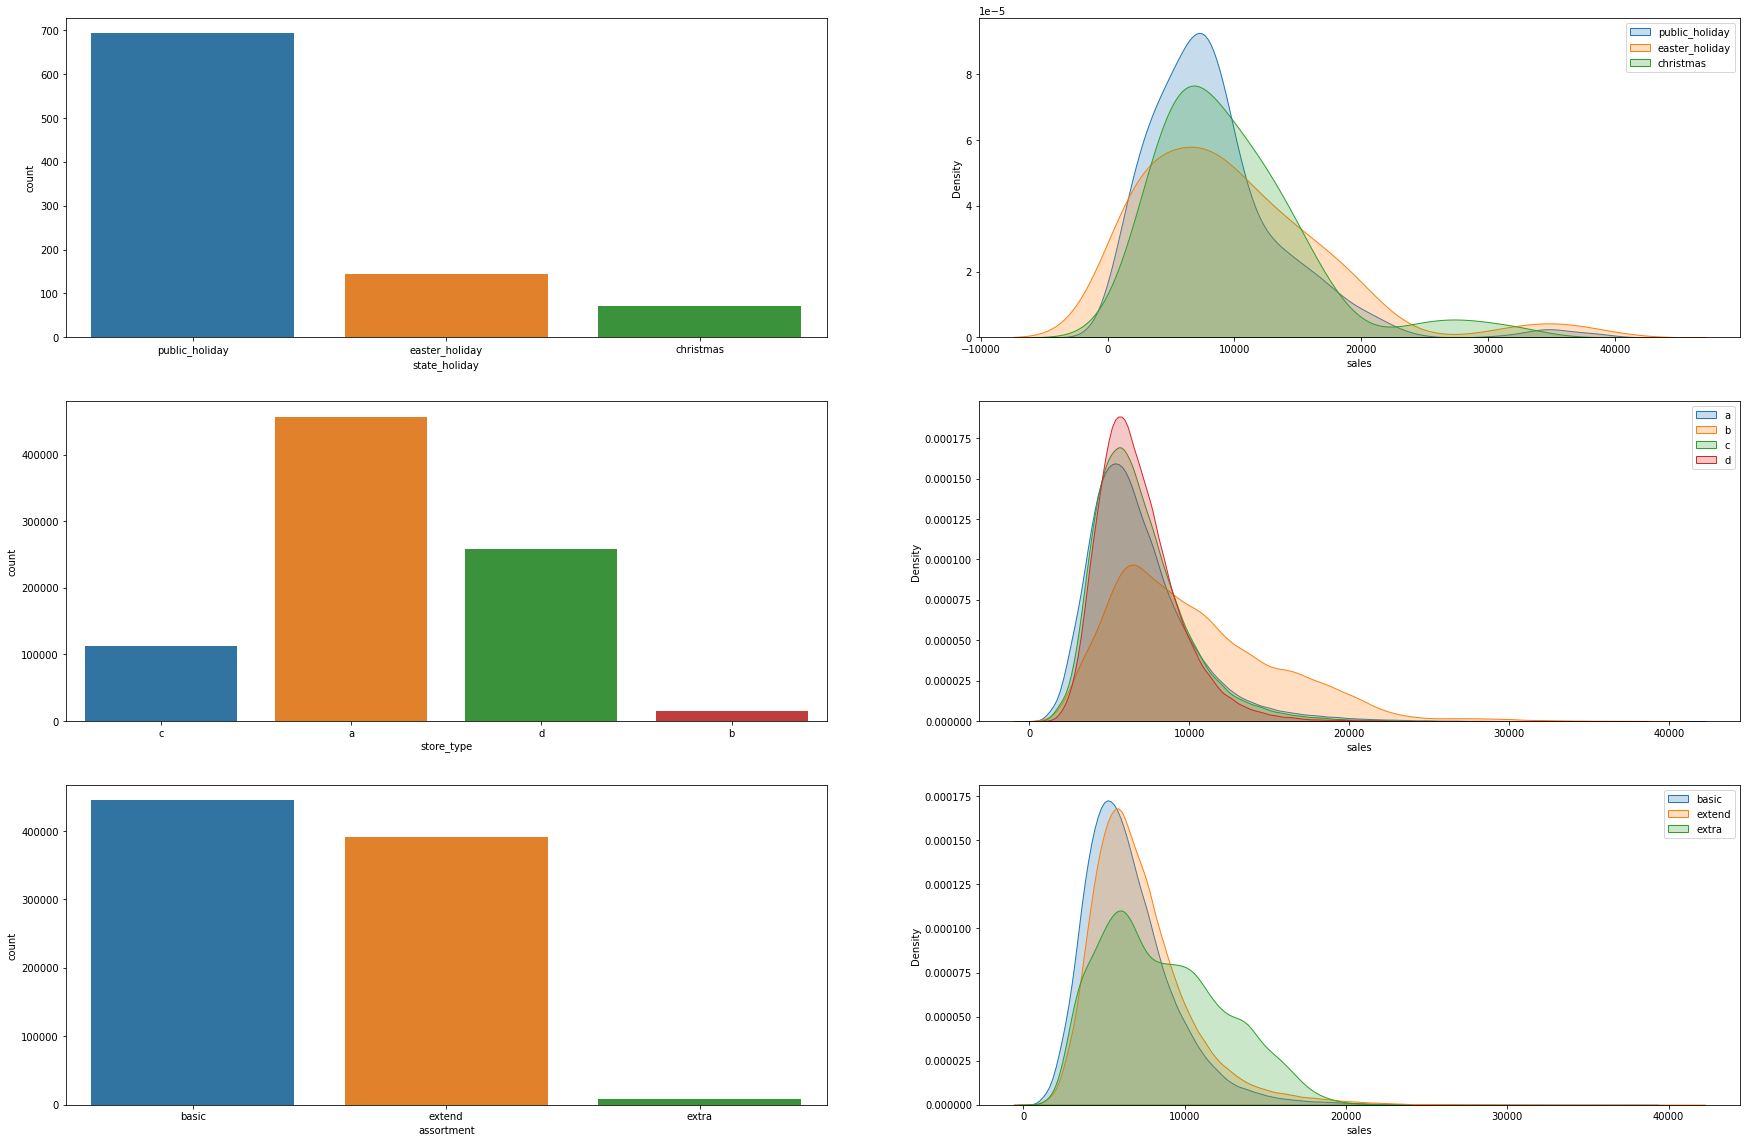

In [19]:
# State Holiday
a = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(3,2,1)
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',shade=True)
plt.legend()

# Store Type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d',shade=True)
plt.legend()

# Assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extend']['sales'], label='extend',shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True)
plt.legend()



## Bivariate Analysis

### H1 - Store with more assortment should have higher sales.
***FALSE***

<AxesSubplot:xlabel='year_week'>

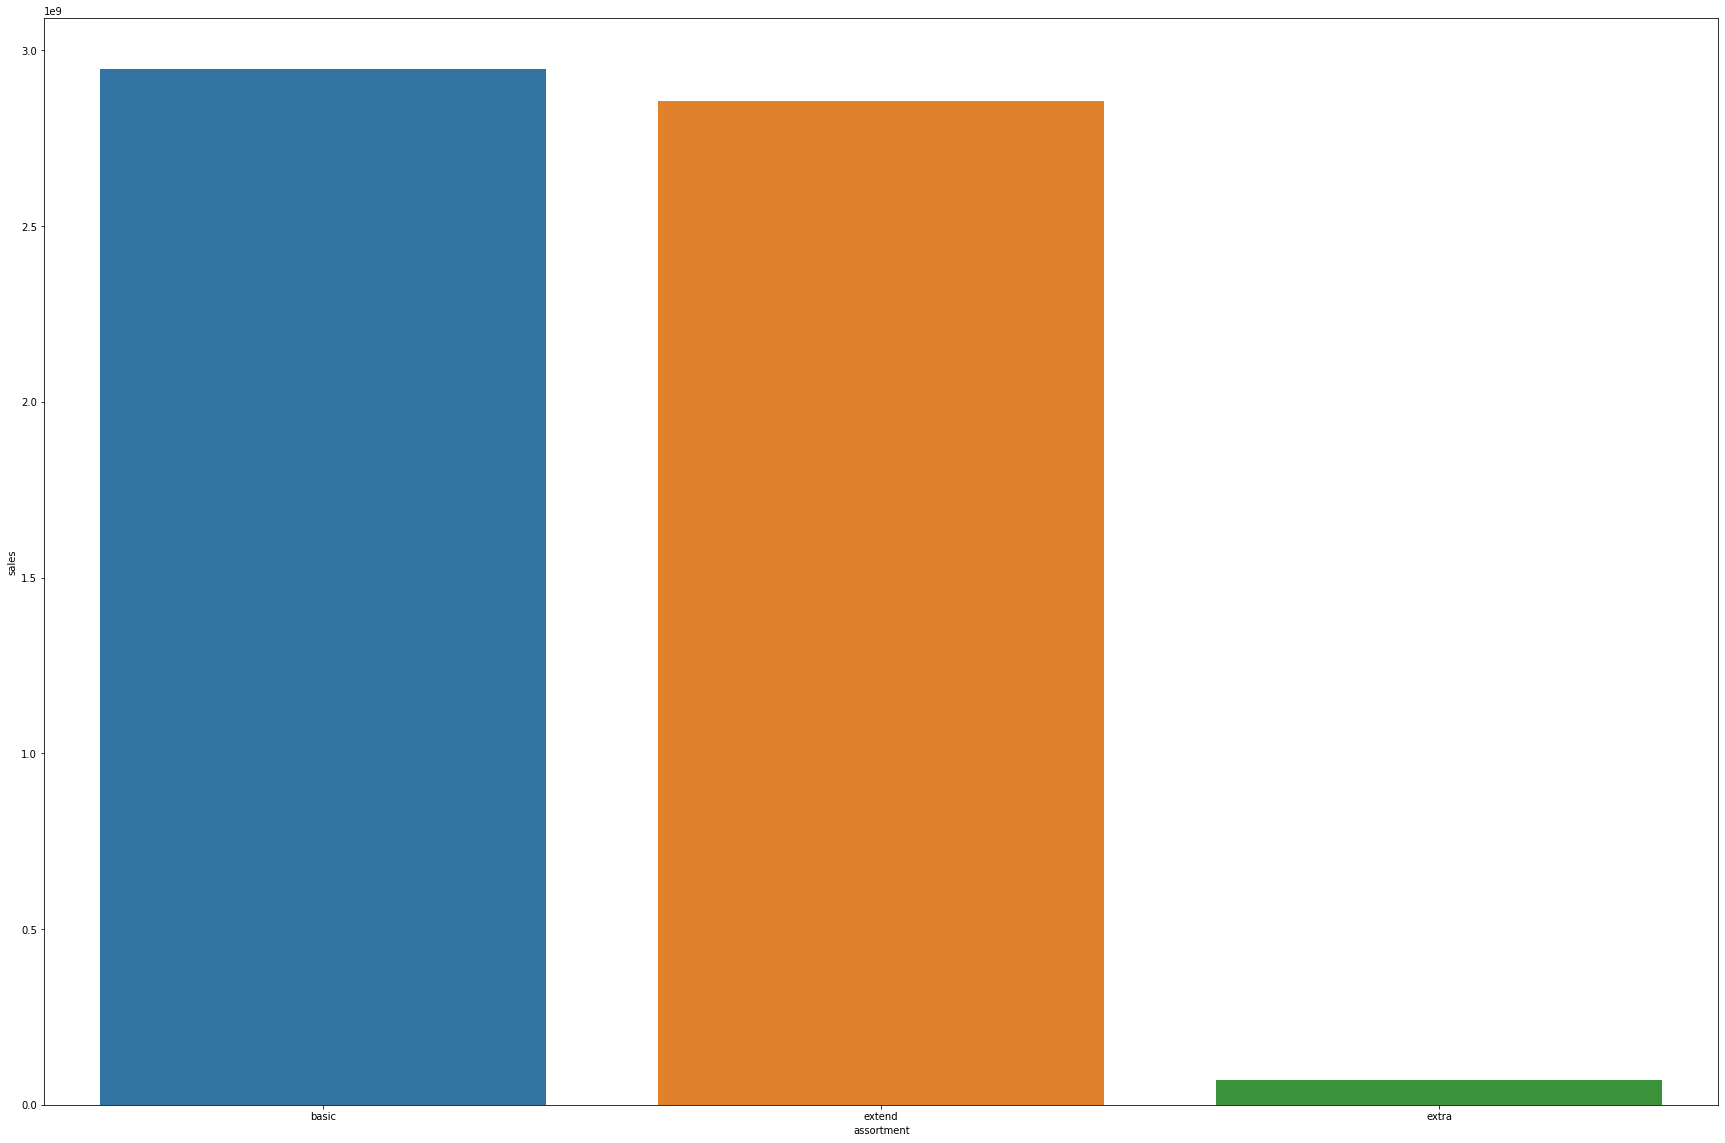

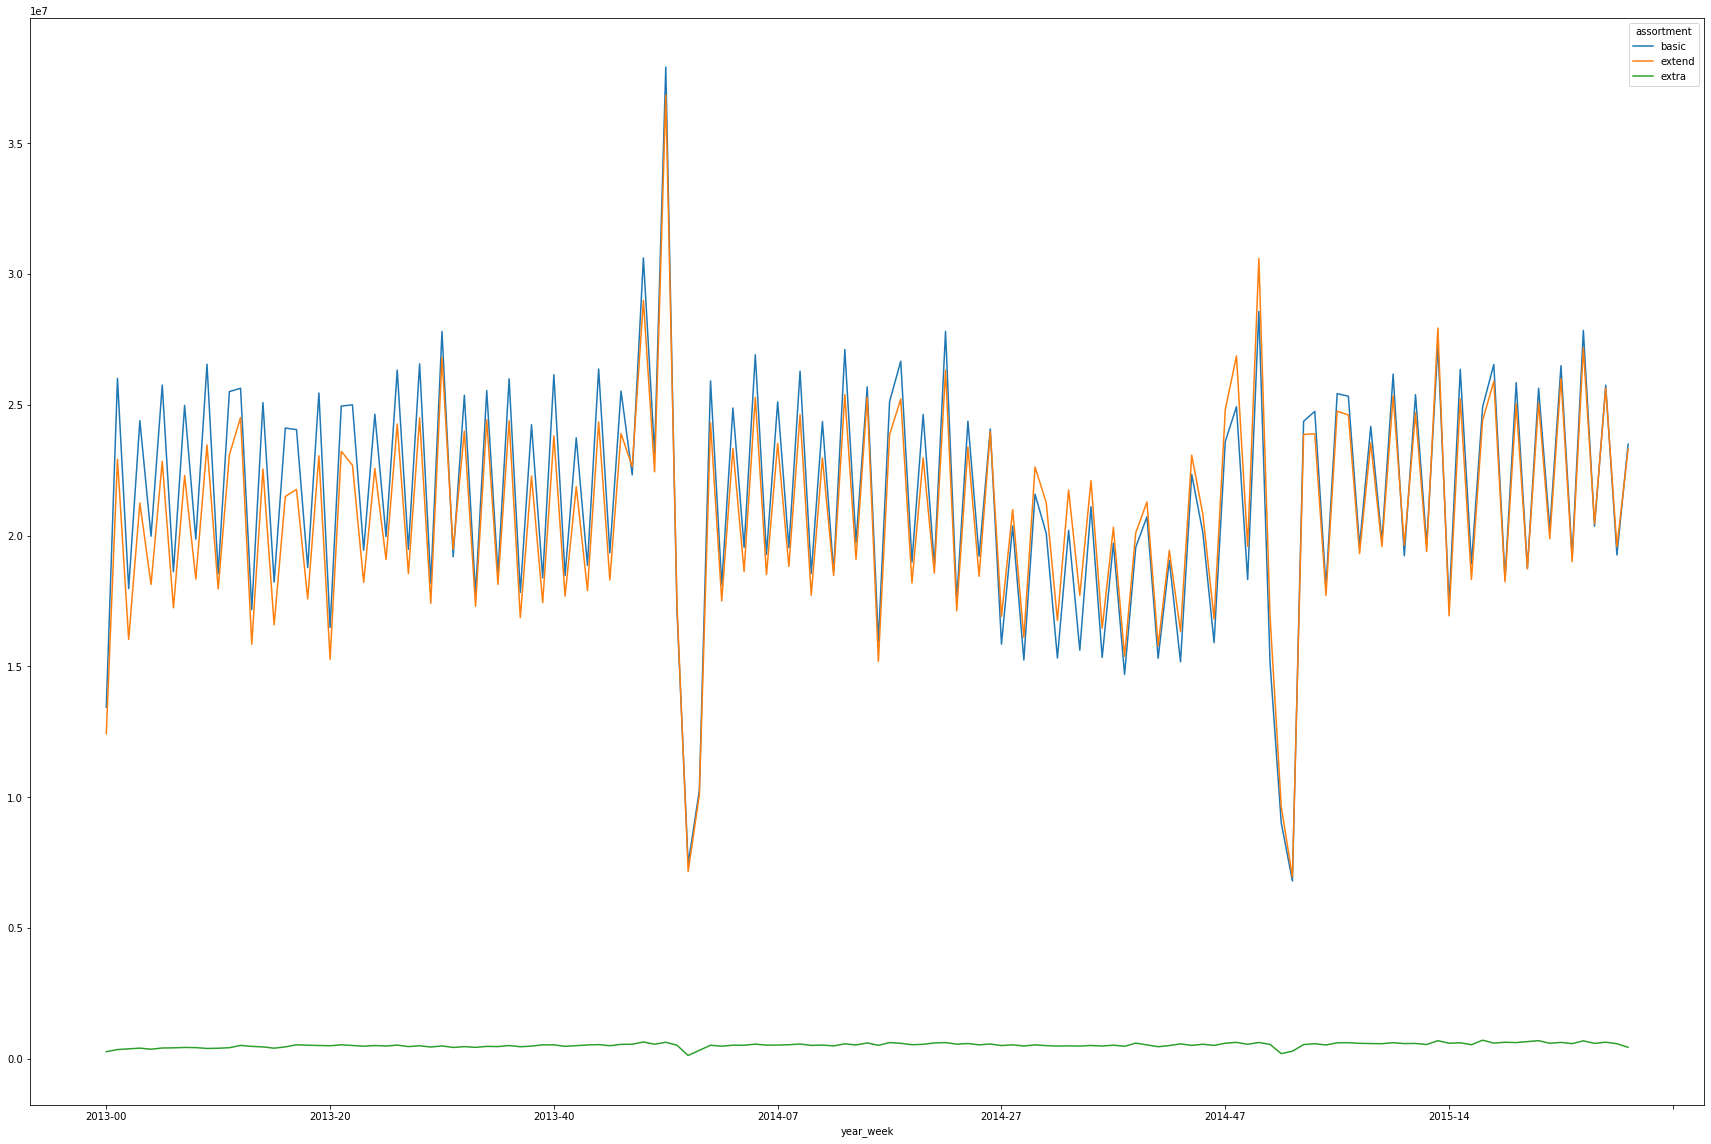

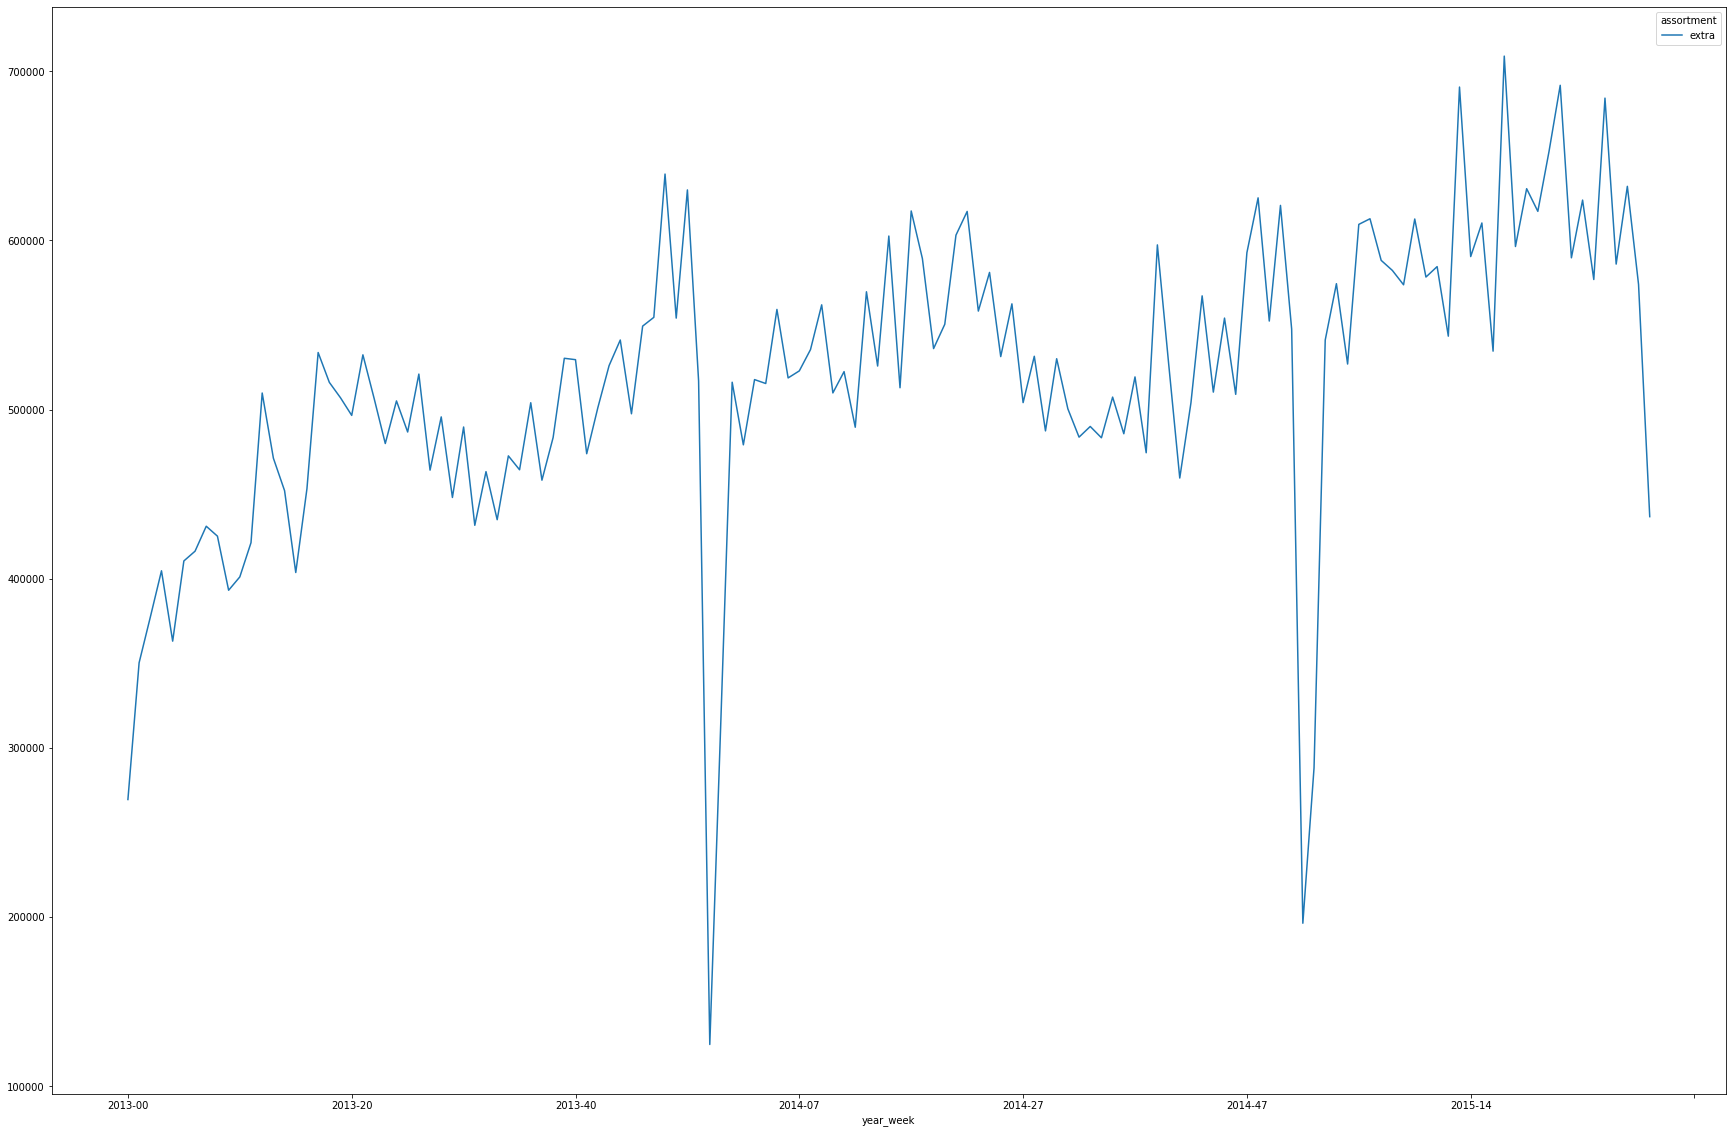

In [20]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot()

### H2 - Store closer to the competitor should have lower sales 
***FALSE***

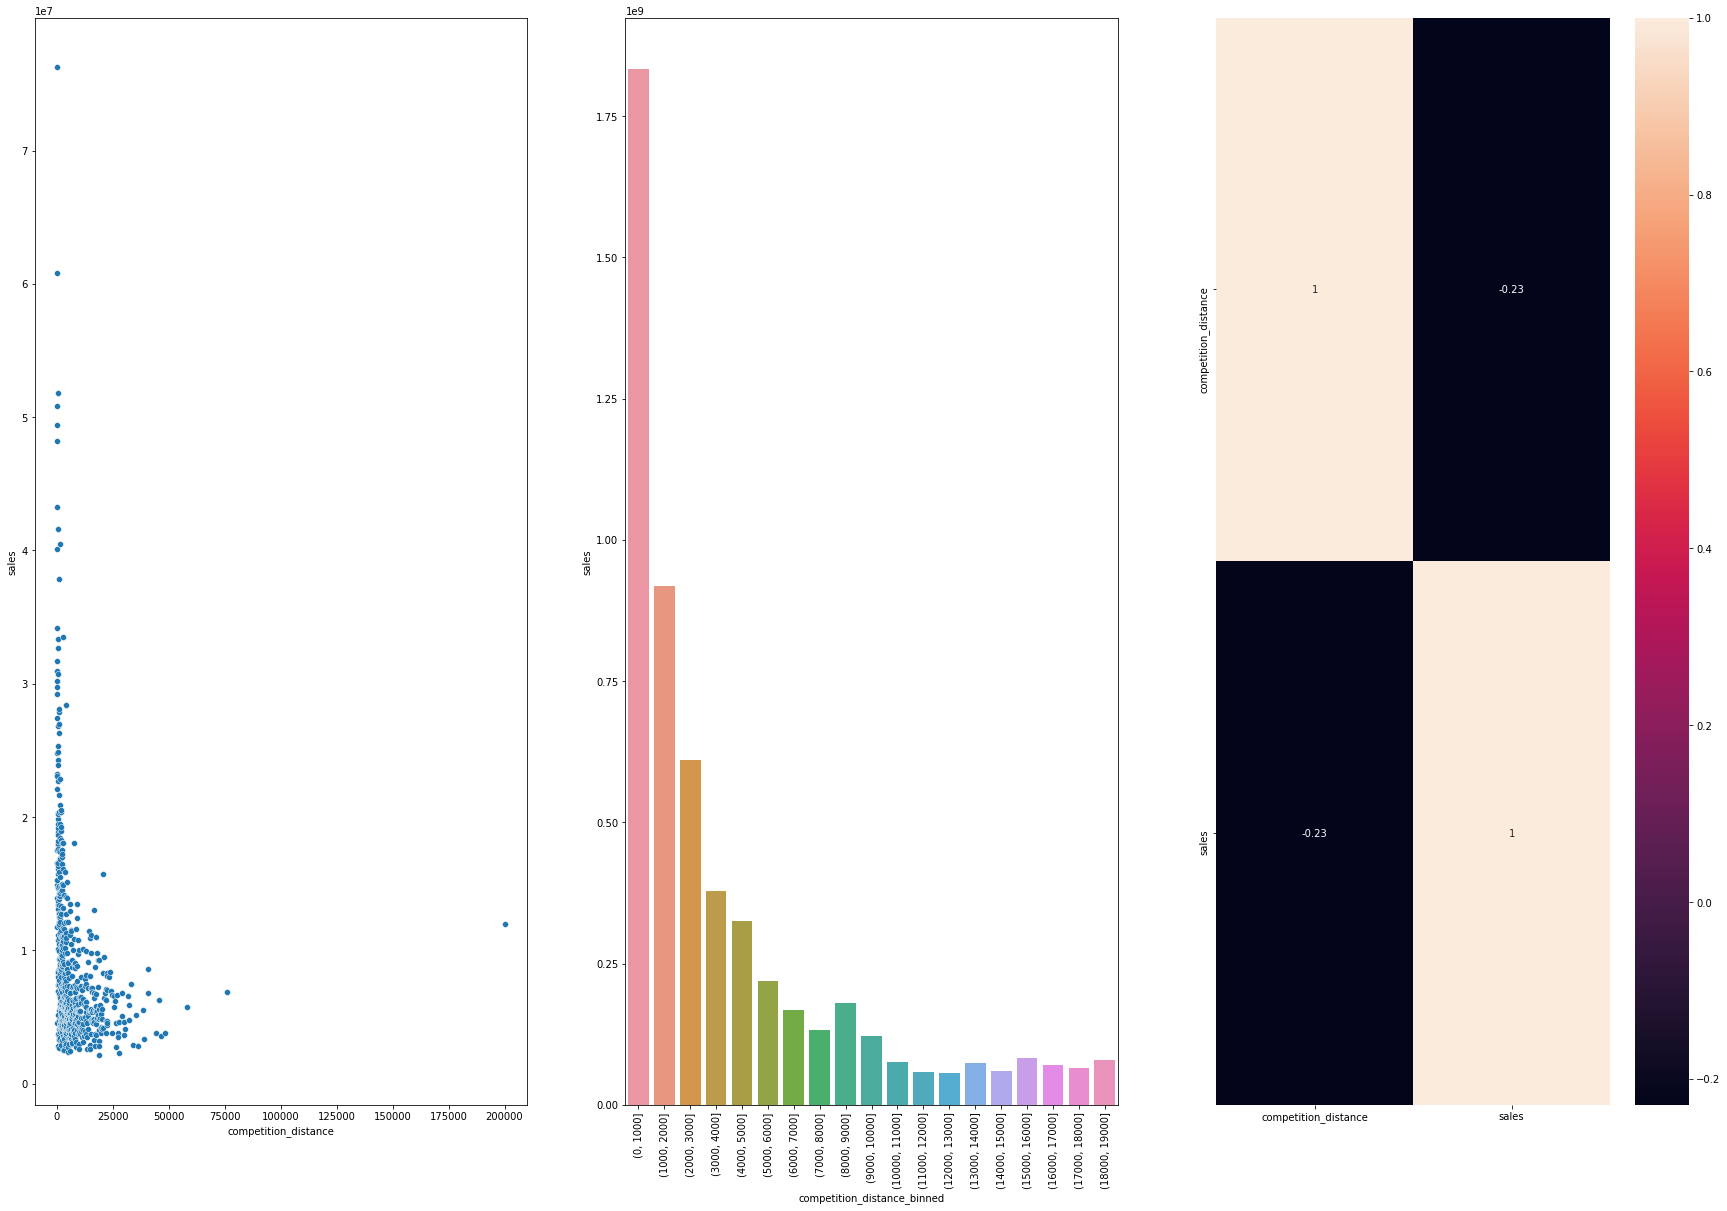

In [21]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H3 - Store with competitors for longer should have higher sales
***FALSE***

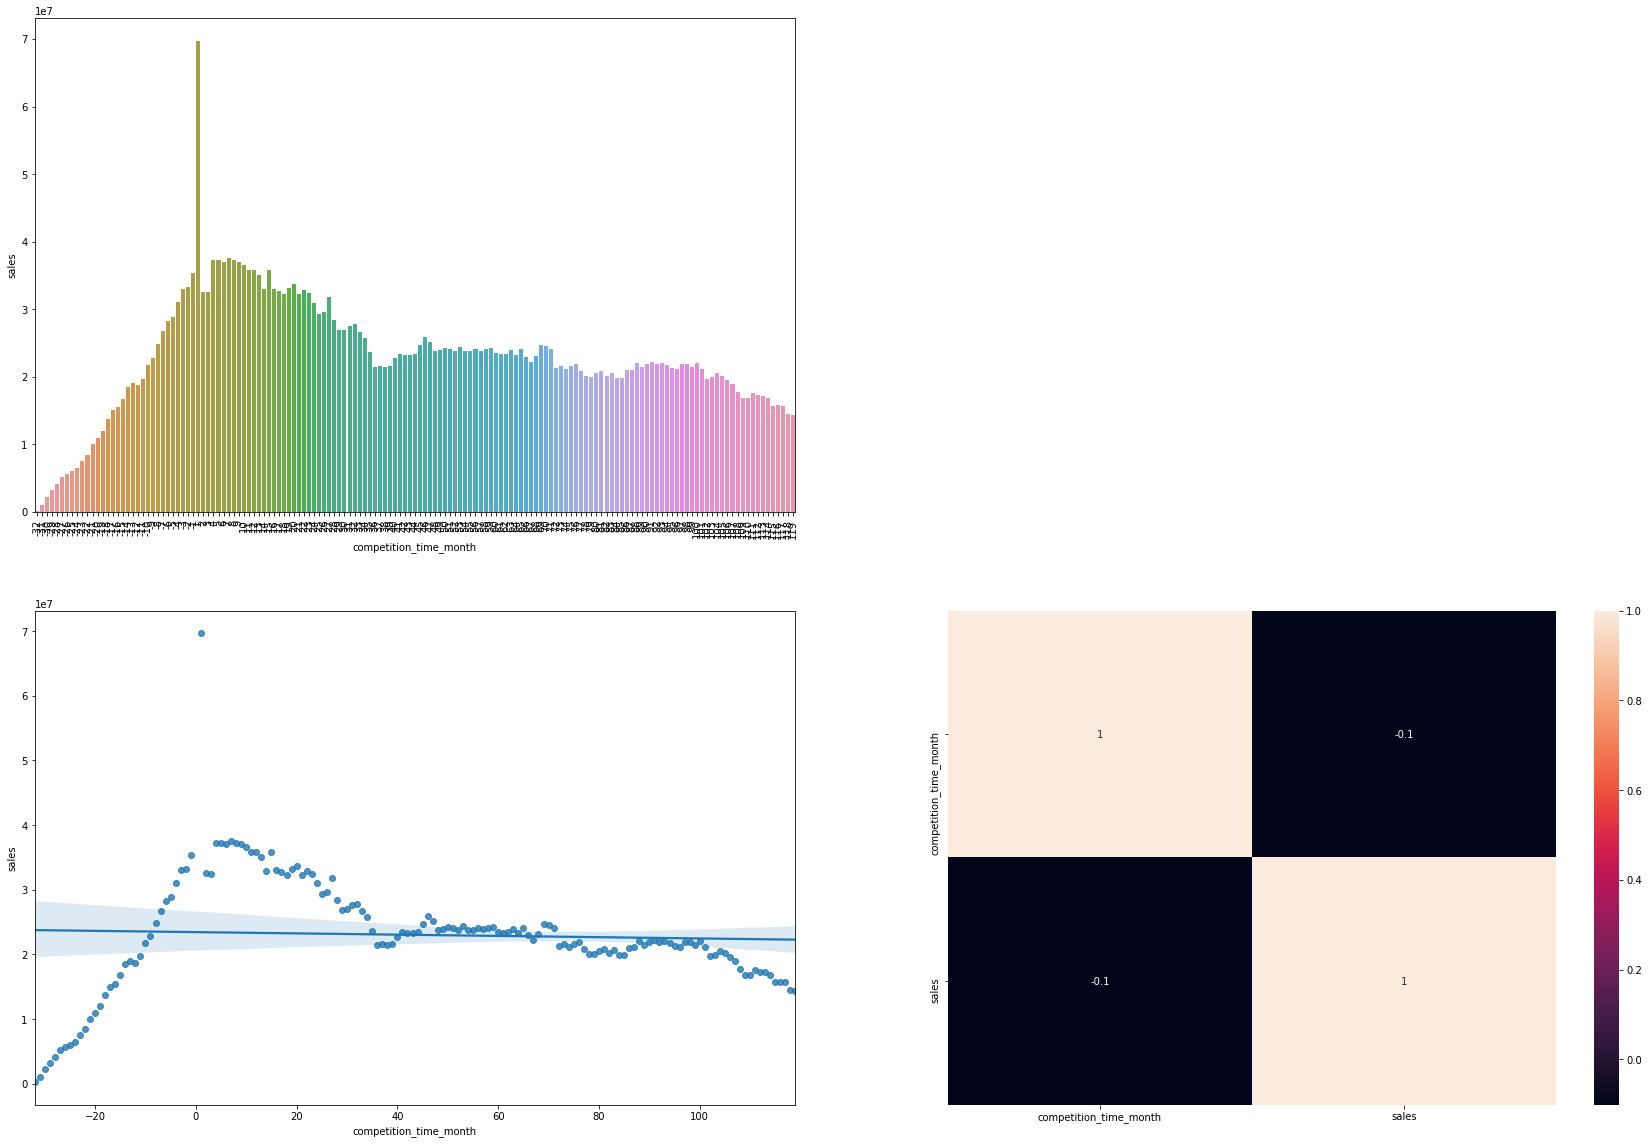

In [22]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120)  & (aux1['competition_time_month'] != 0)]

plt.subplot(2,2,1)
sns.barplot(x='competition_time_month',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(2,2,3)
sns.regplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(2,2,4)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H4 - Stores with longer activated promotions should have higher sales. 
***FALSE***

<AxesSubplot:>

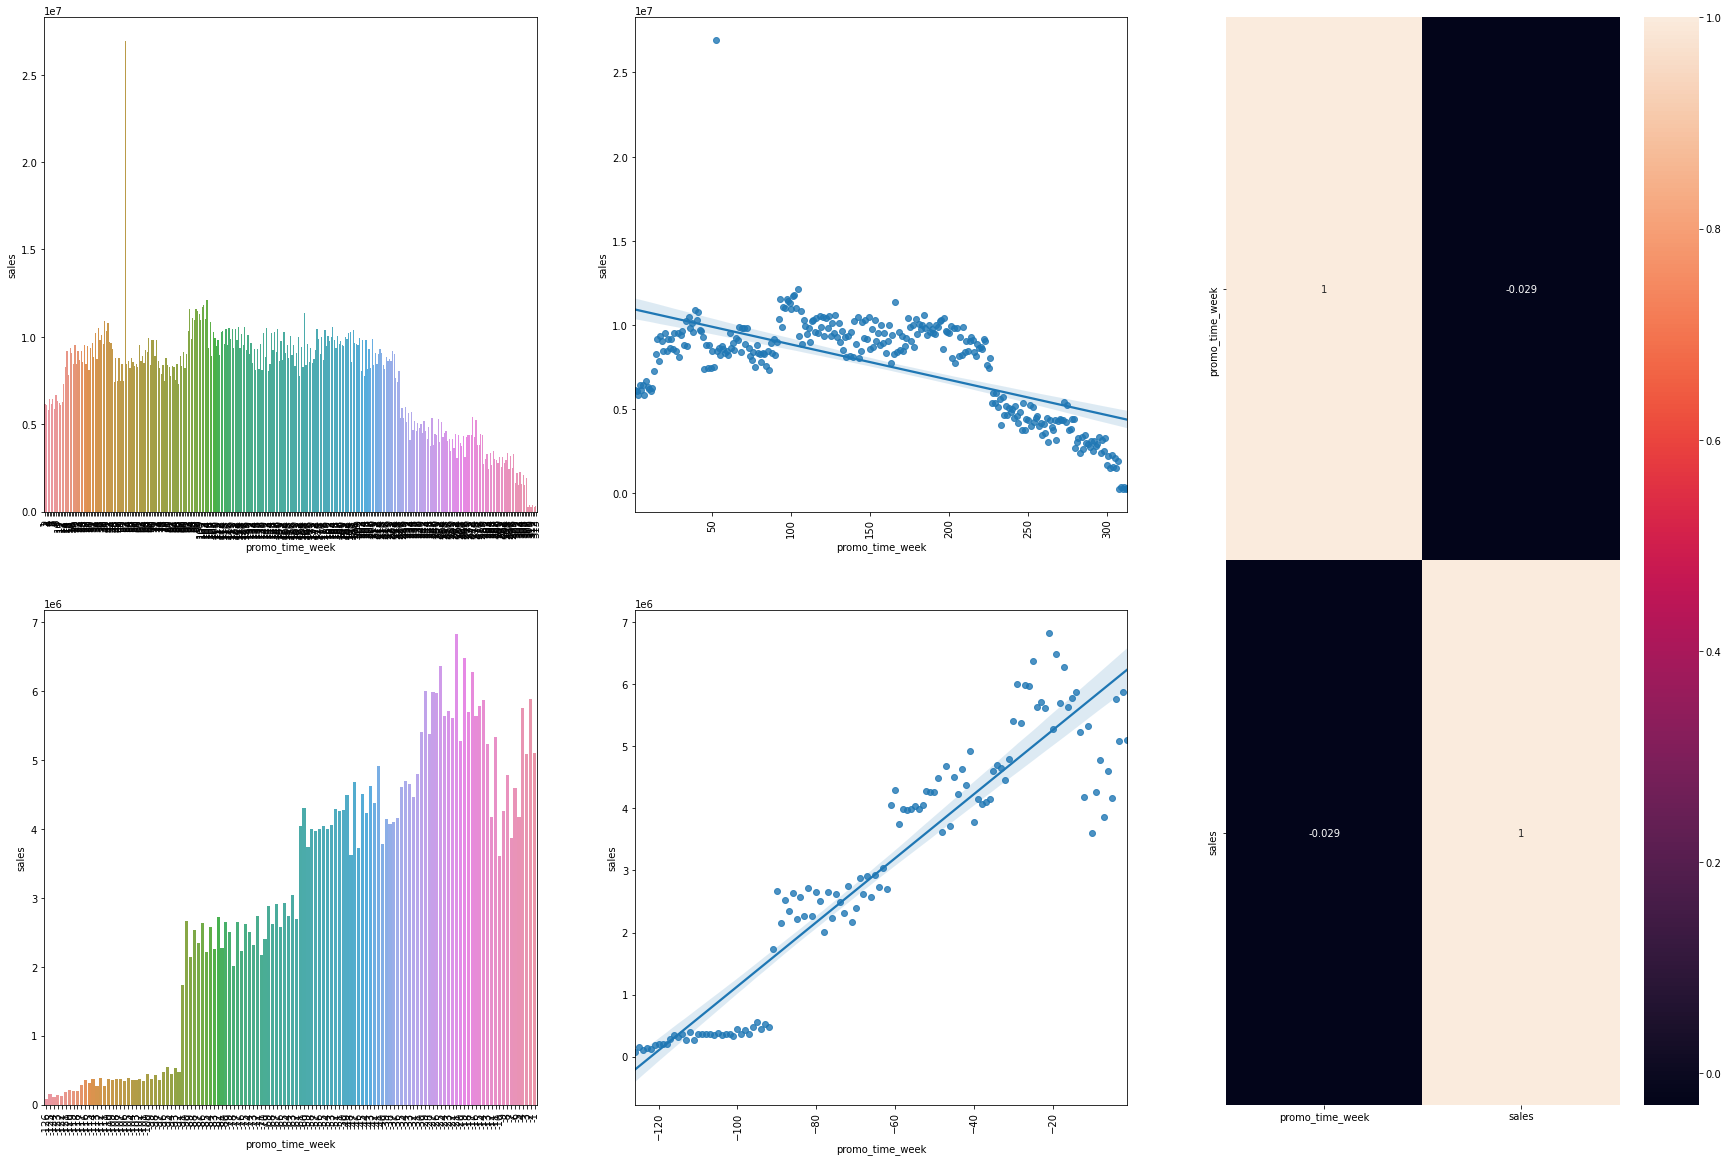

In [23]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x='promo_time_week',y='sales',data=aux1);

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] # promo extend period
sns.barplot(x='promo_time_week',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux2);
plt.xticks(rotation=90);


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] # promo regular period
sns.barplot(x='promo_time_week',y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)

In [24]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extend,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### <s> H5 - Stores with more days in promotion should have higher sales. </s>

### H6 - Stores with more consecutives promotions should have higher sales.
**FALSE**

In [25]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


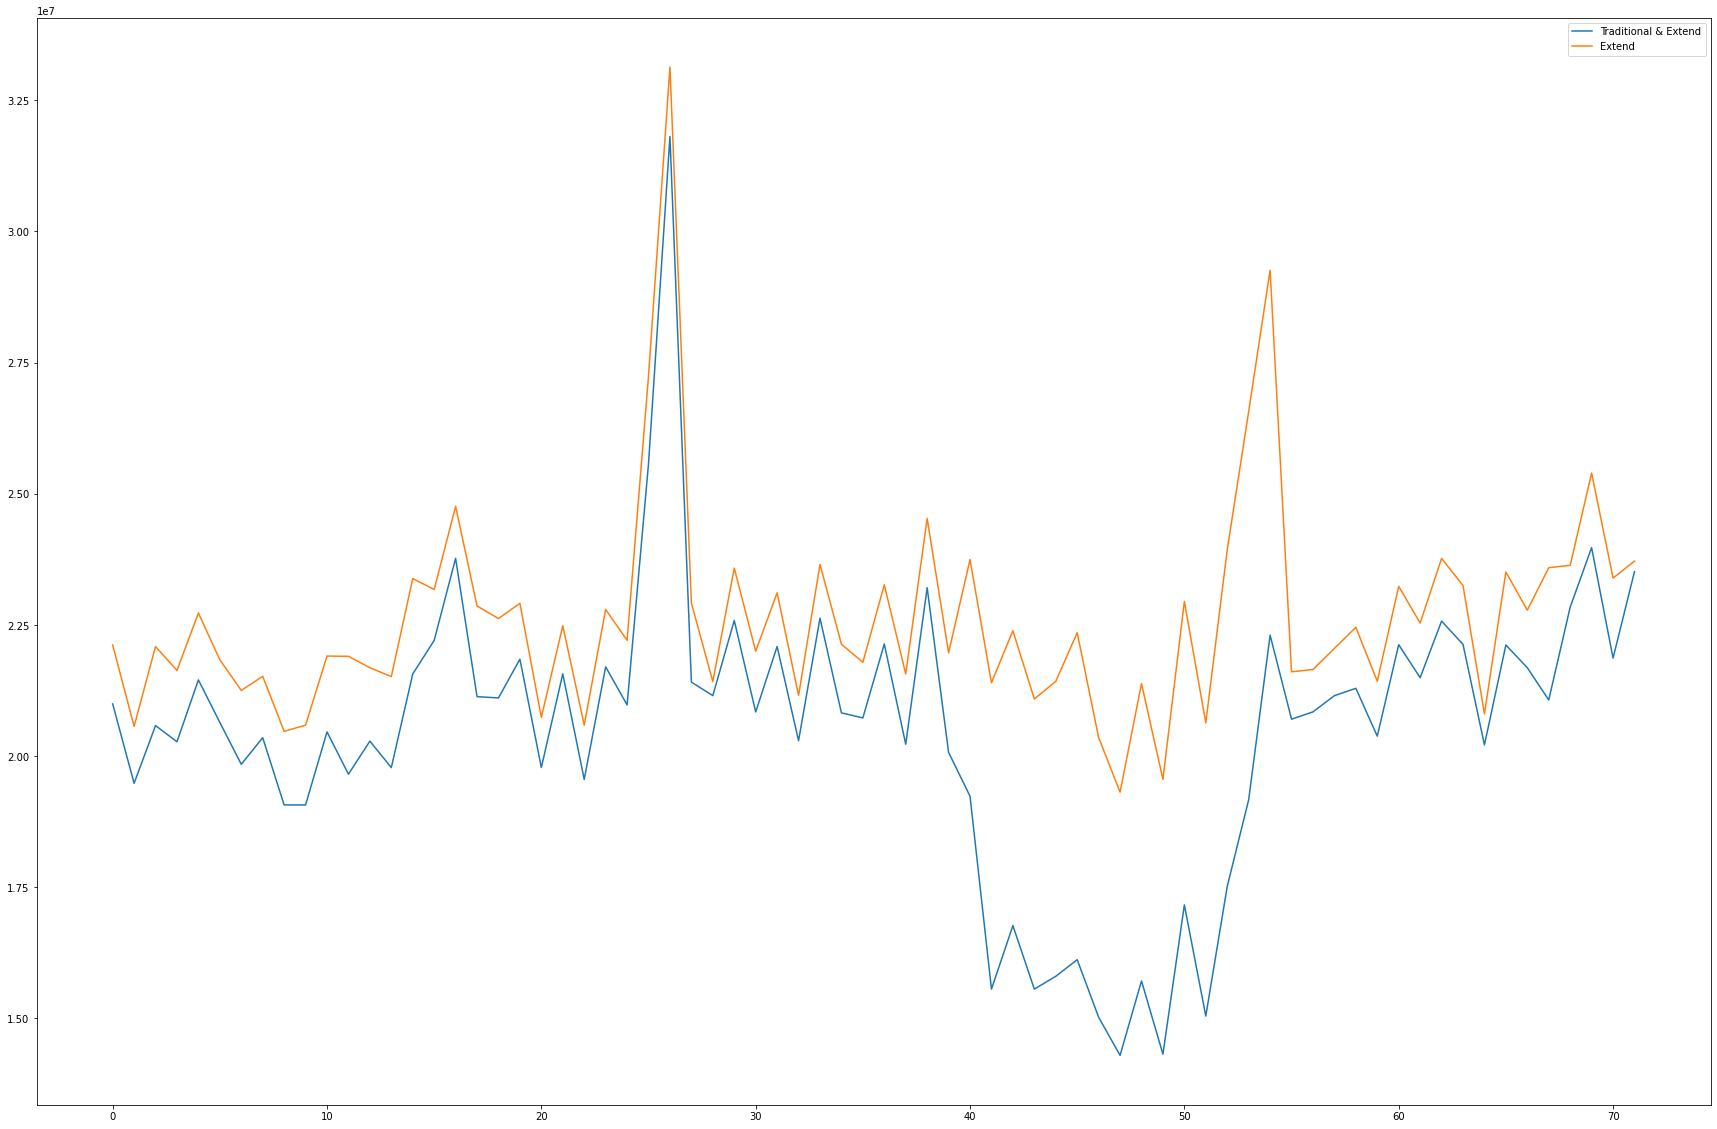

In [26]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional & Extend','Extend'])

### H7 - Stores open during Christmas period should have higher sales.
***FALSE***

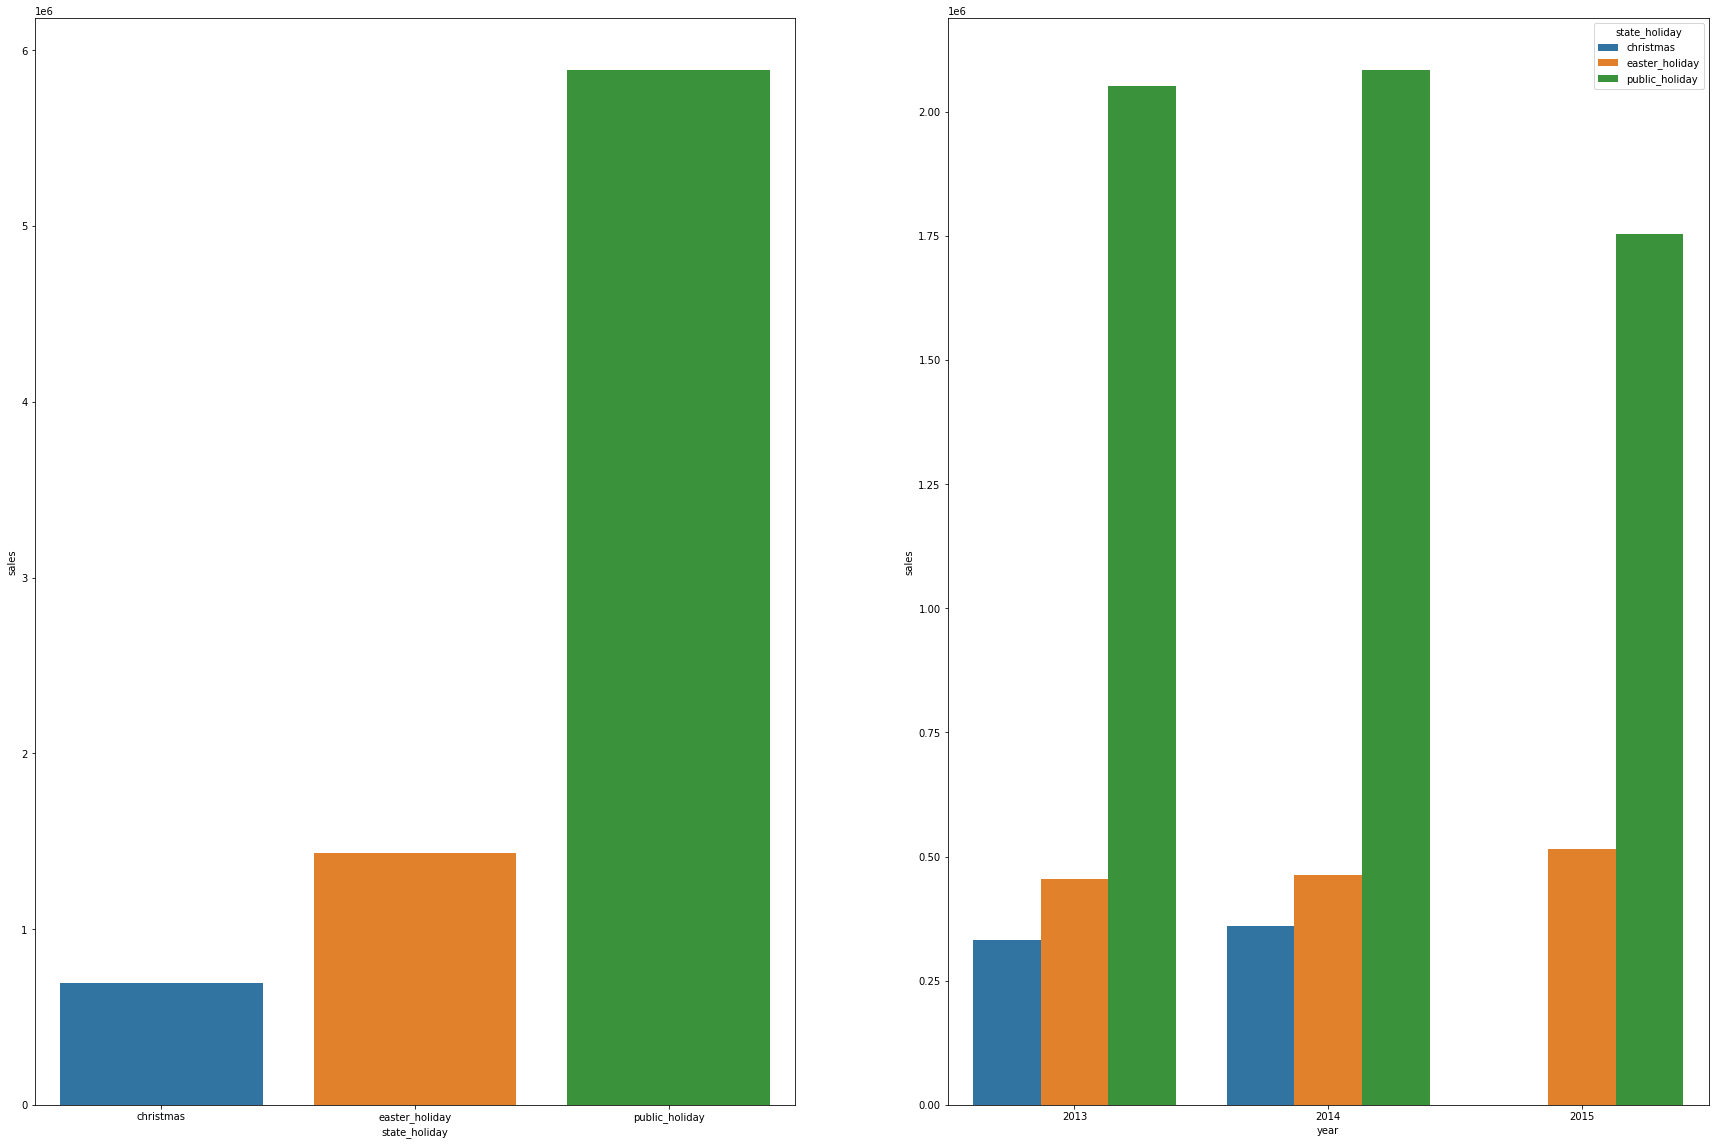

In [27]:
aux = df4[df4['state_holiday']!='regular_day']
plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2);

### H8 - Stores should increase their sales year by year
***FALSE***

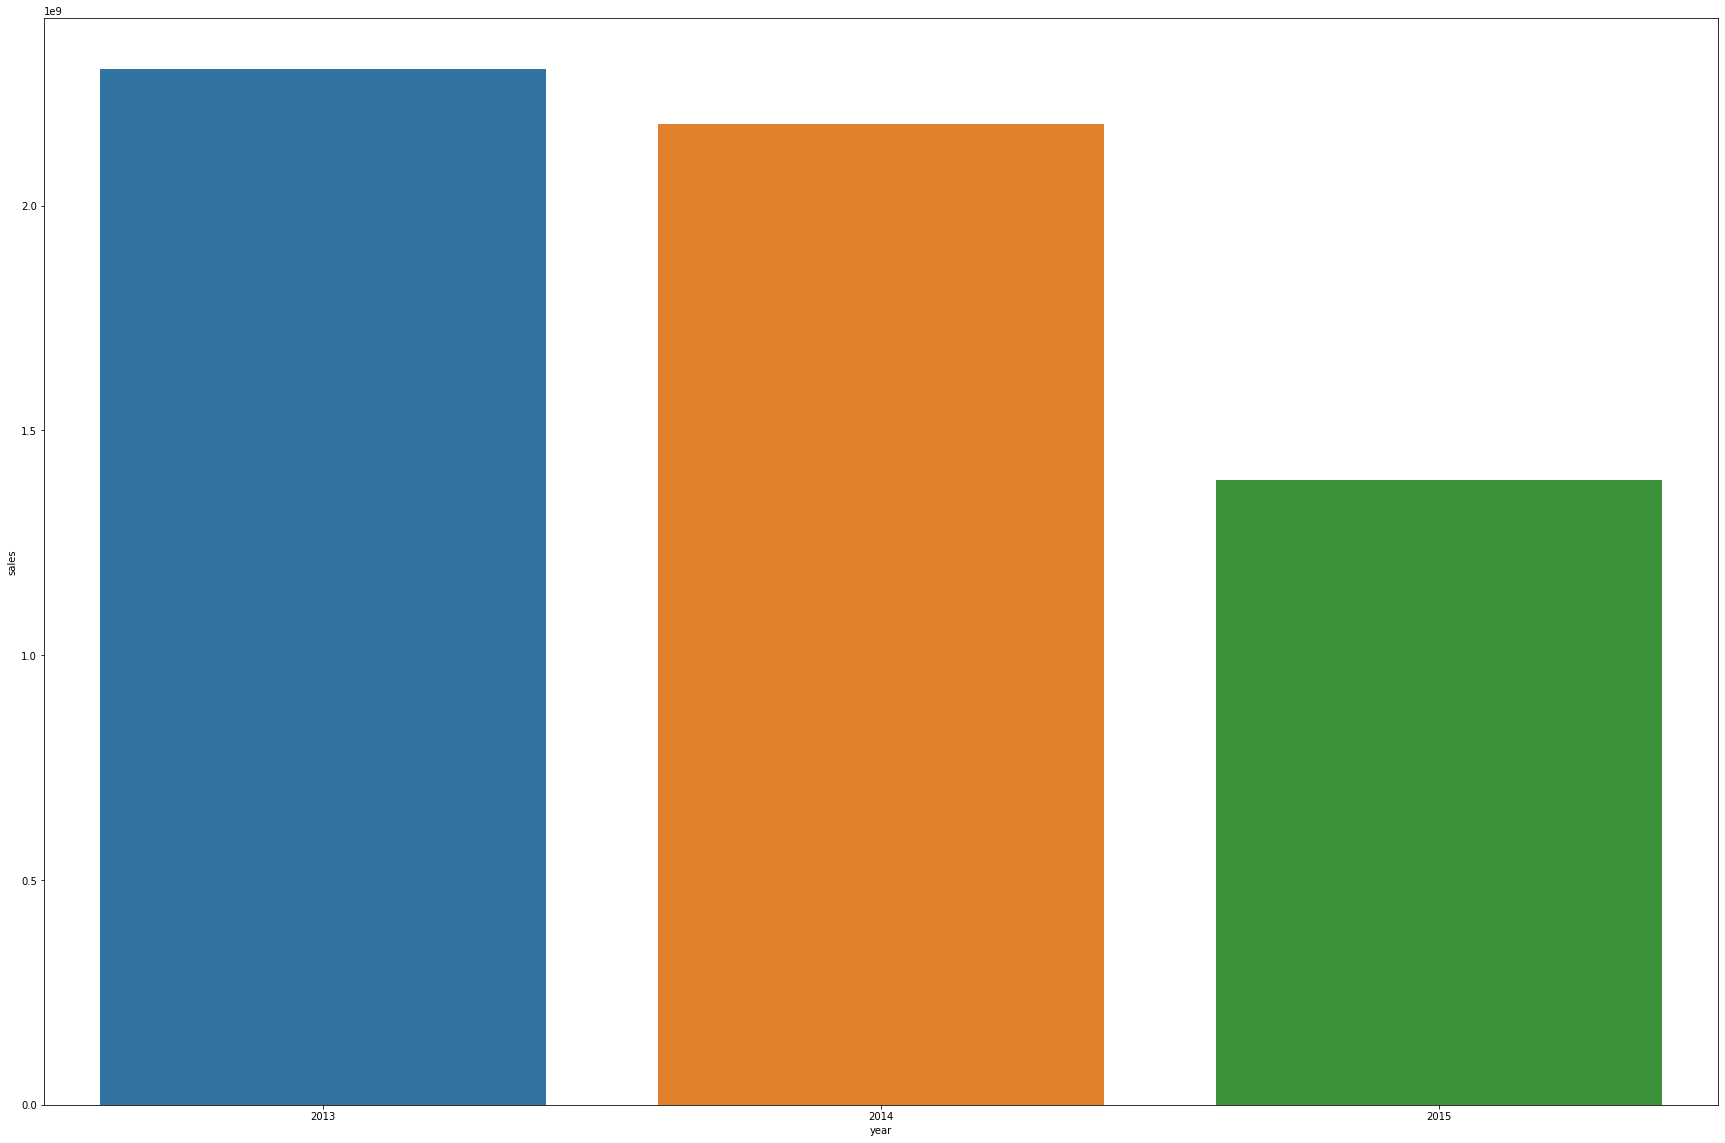

In [28]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year',y='sales',data=aux1);

### H9 - Stores should have higher sales on the second half of the year
**FALSE** **

In [29]:
## Modulo 4, Video 4 - Acredito que Meigarom deixou de considerar que o ano de 2015 não tem todos os dados. 
## vou pular essa etapa.

#m1 = df4[df4['month']<=6]
#m2 = df4[df4['month']>=7]

#aux1 = m1[['year','sales']].groupby('year').sum().reset_index()
#aux2 = m2[['year','sales']].groupby('year').sum().reset_index()

#plt.subplot(1,2,1)
#sns.barplot(x='year',y='sales',data=aux1);

#plt.subplot(1,2,2)
#sns.barplot(x='year',y='sales',data=aux2);


### H10 - Stores should have higher sales after the 10th of each month
**FALSE** (Stores sell more in the first 10 days of the month if we compare the same period within the month)

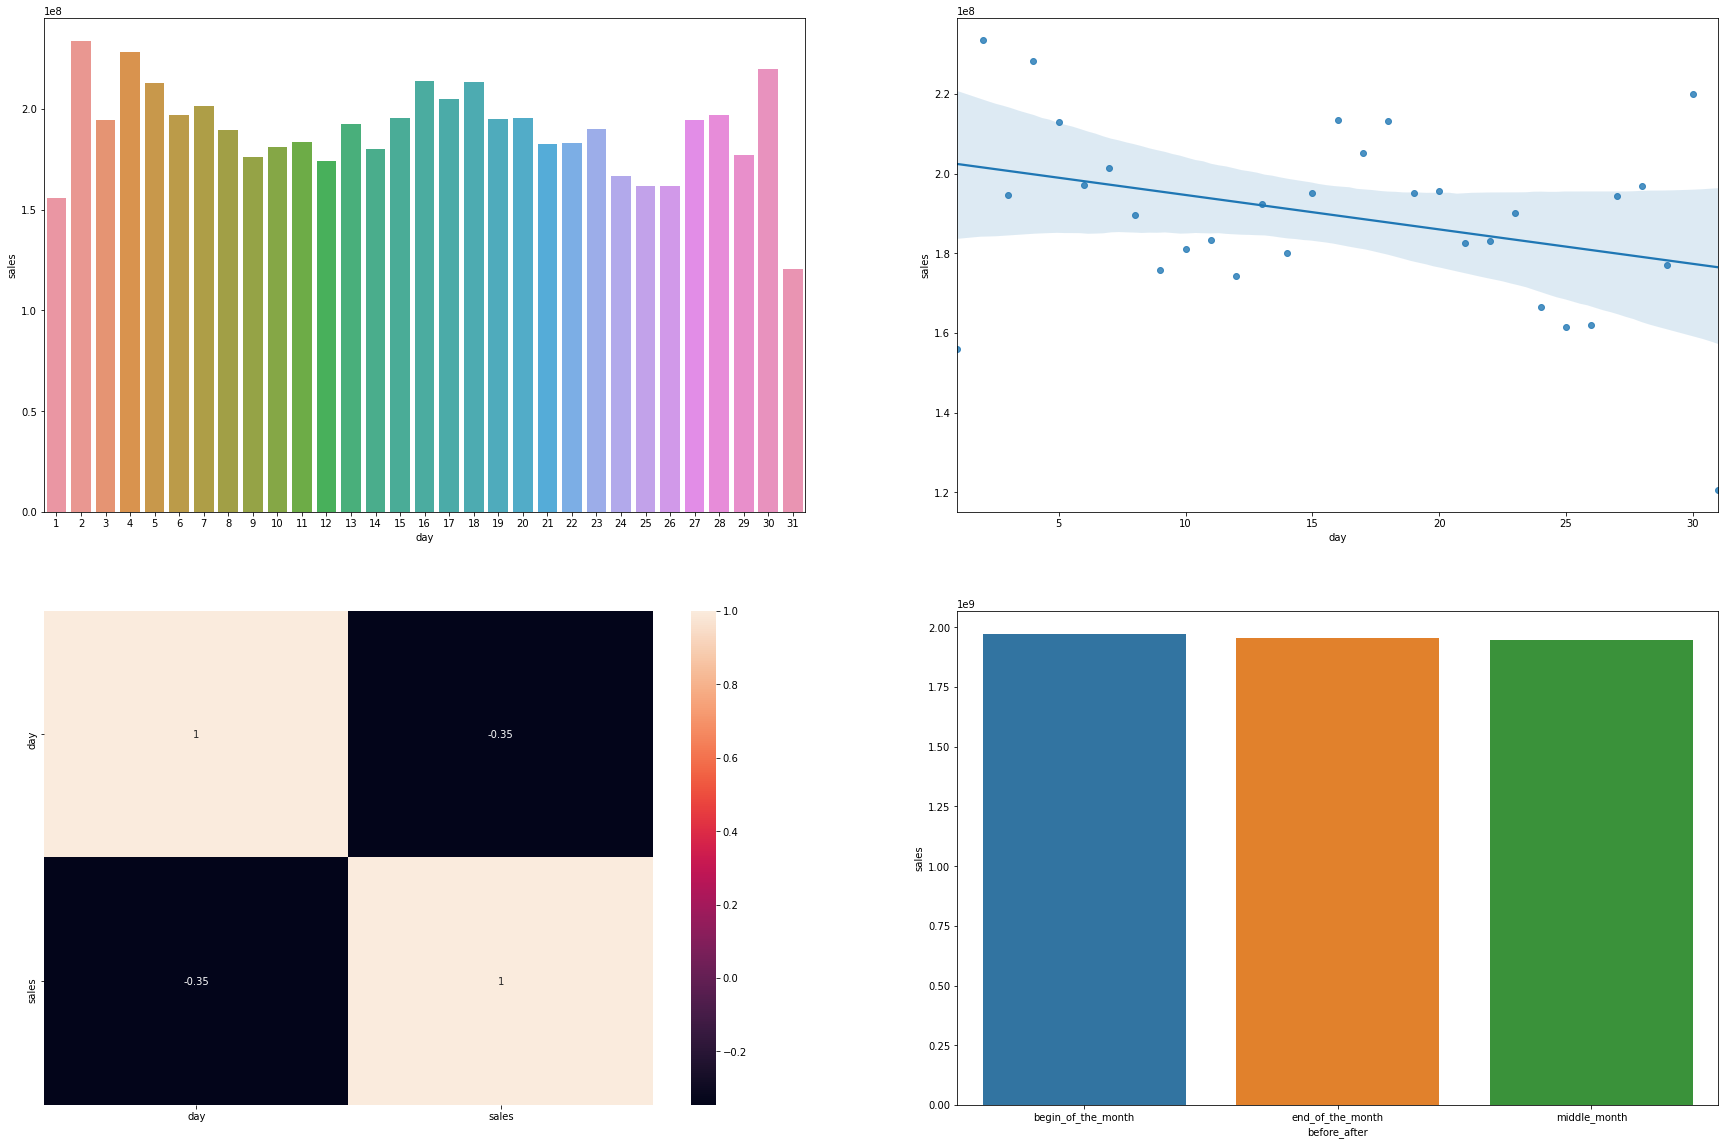

In [30]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'begin_of_the_month' if x<=10 else 'middle_month' if (x>=11) & (x<=20) else 'end_of_the_month')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2);


### H11 - Stores should have lower sales on weekends
***TRUE***

<AxesSubplot:>

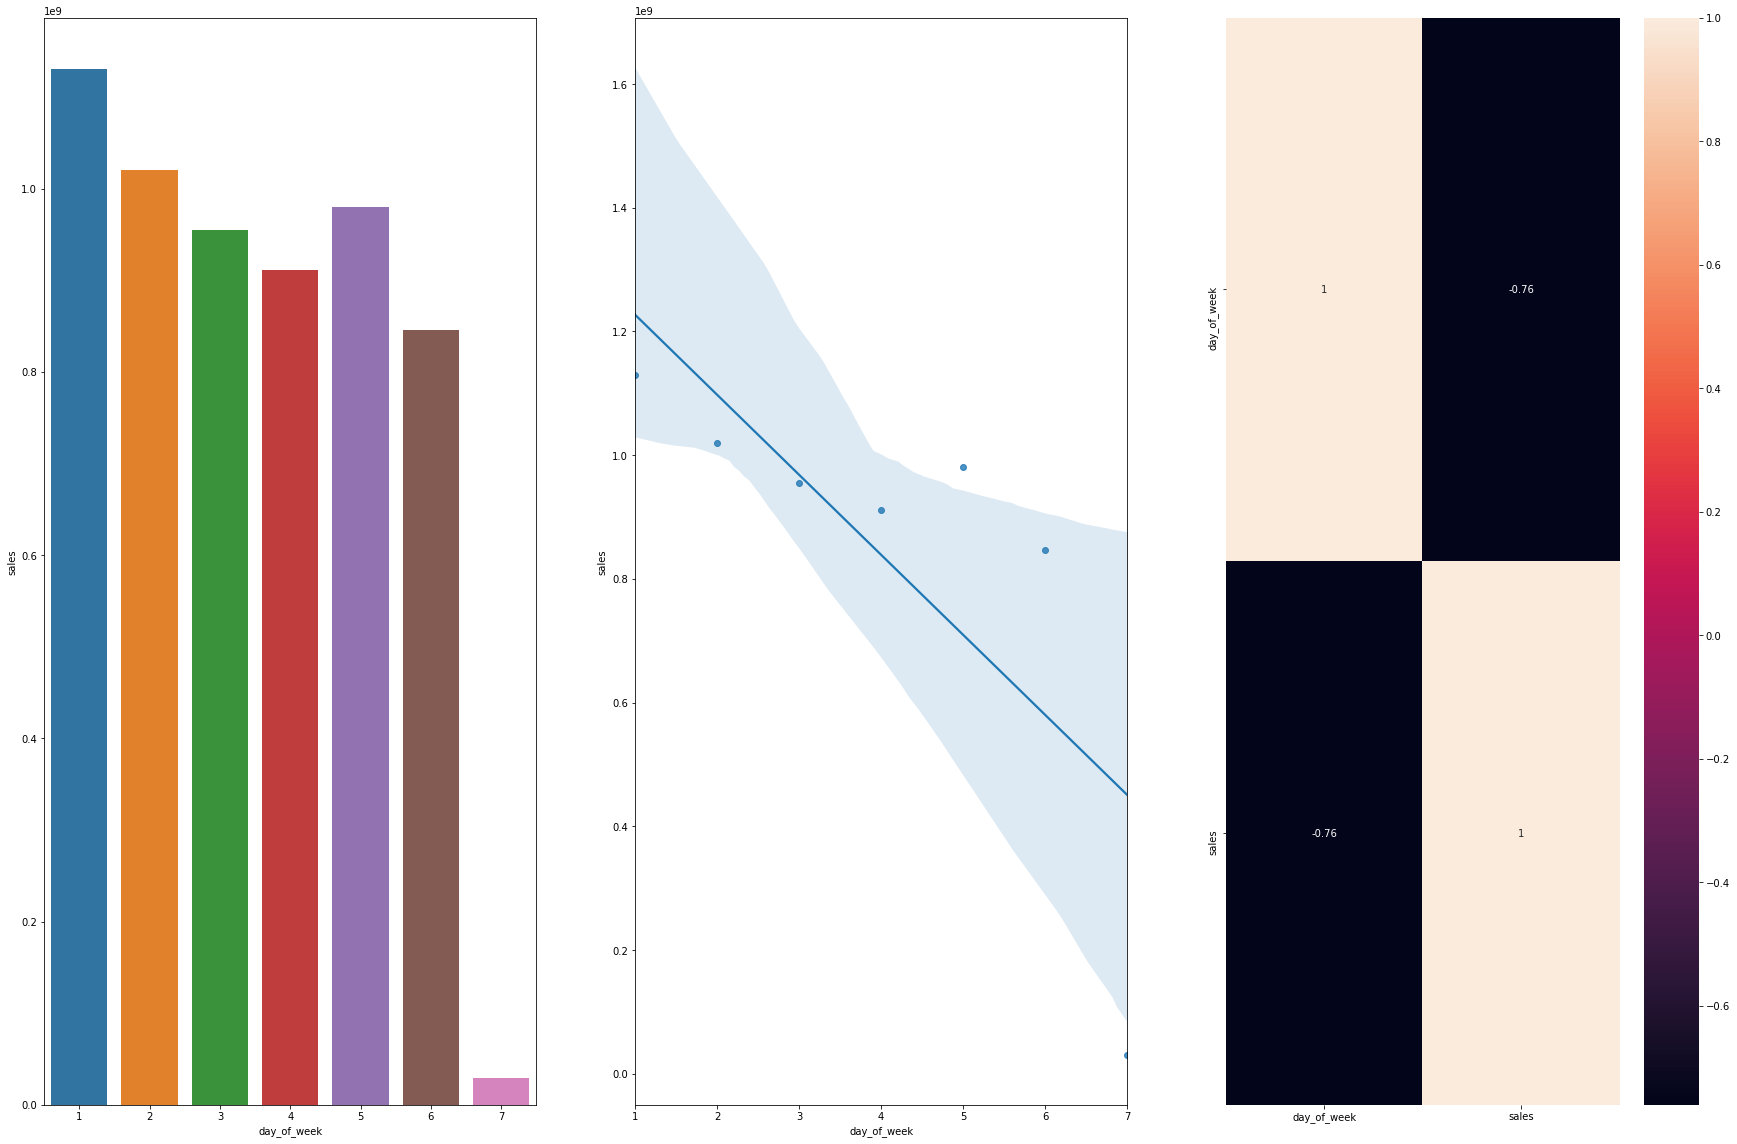

In [31]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H12 - Stores should have lower sales on school holidays
***TRUE*** (Except July and August)

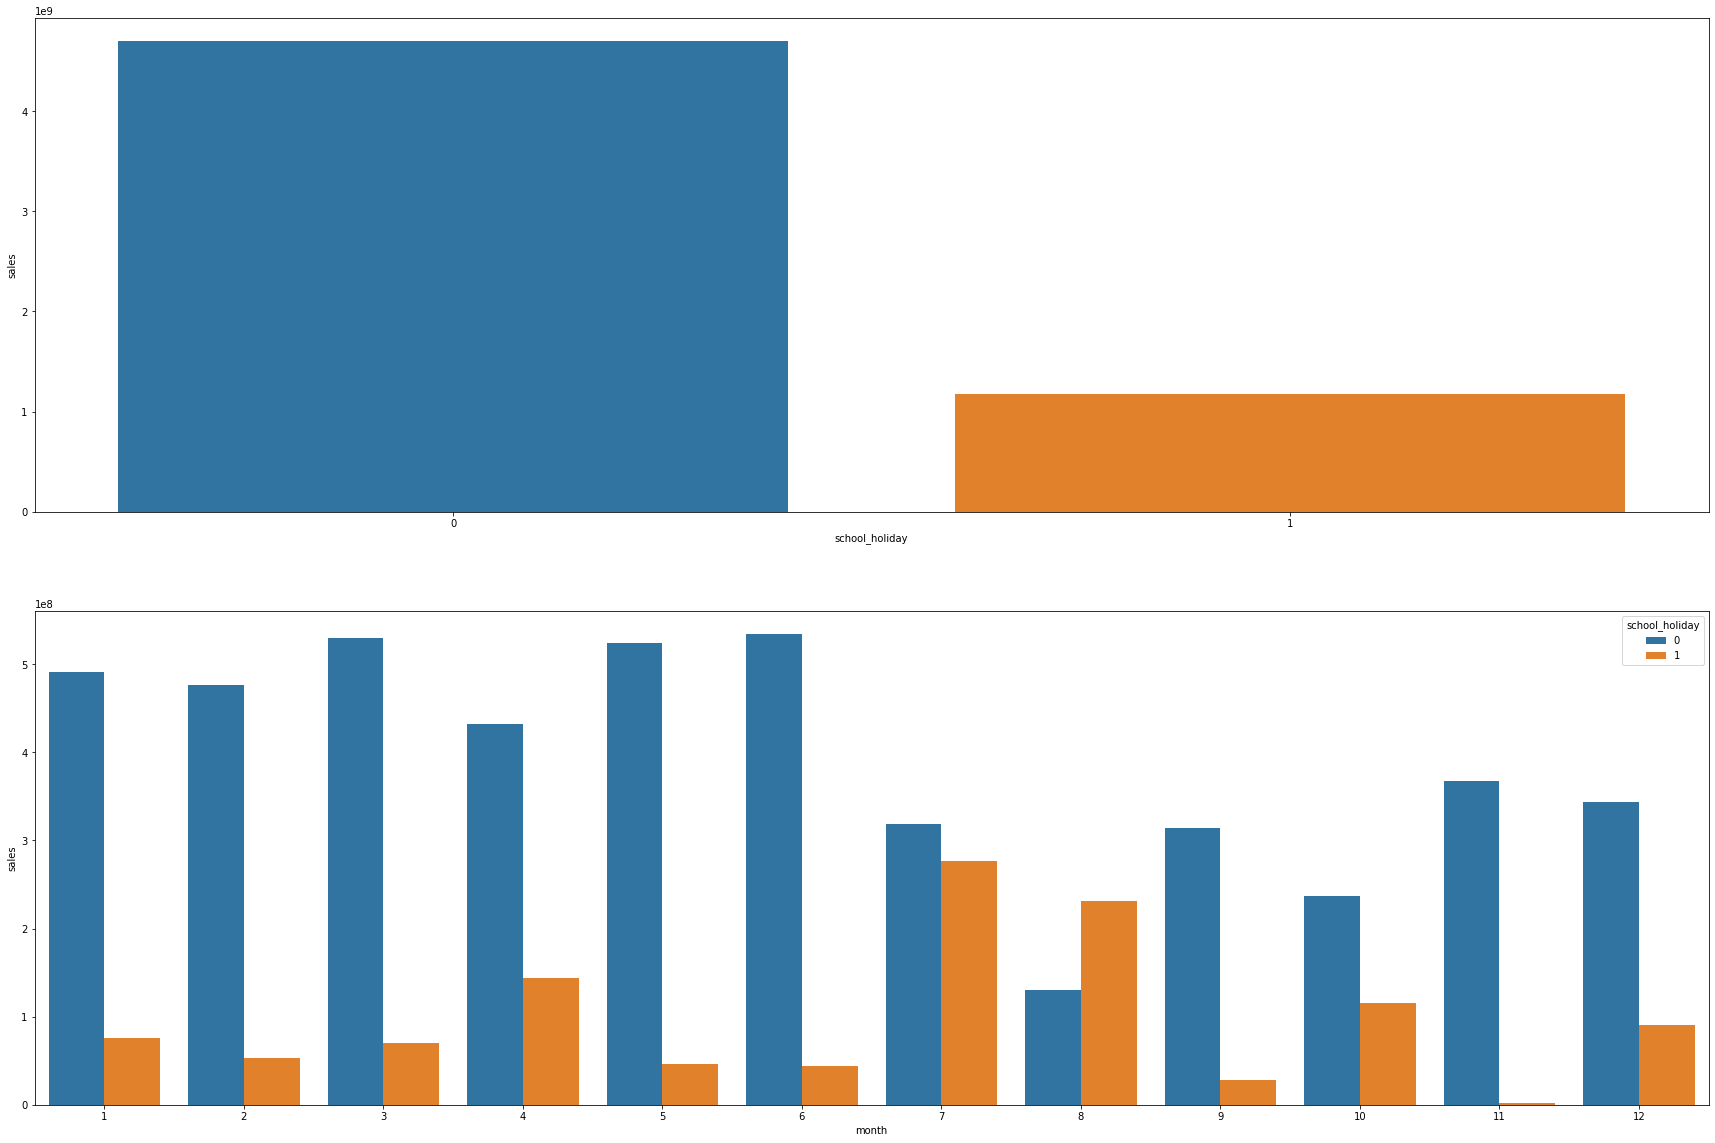

In [32]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

## Multivariate Analysis

### Numerical Attributes

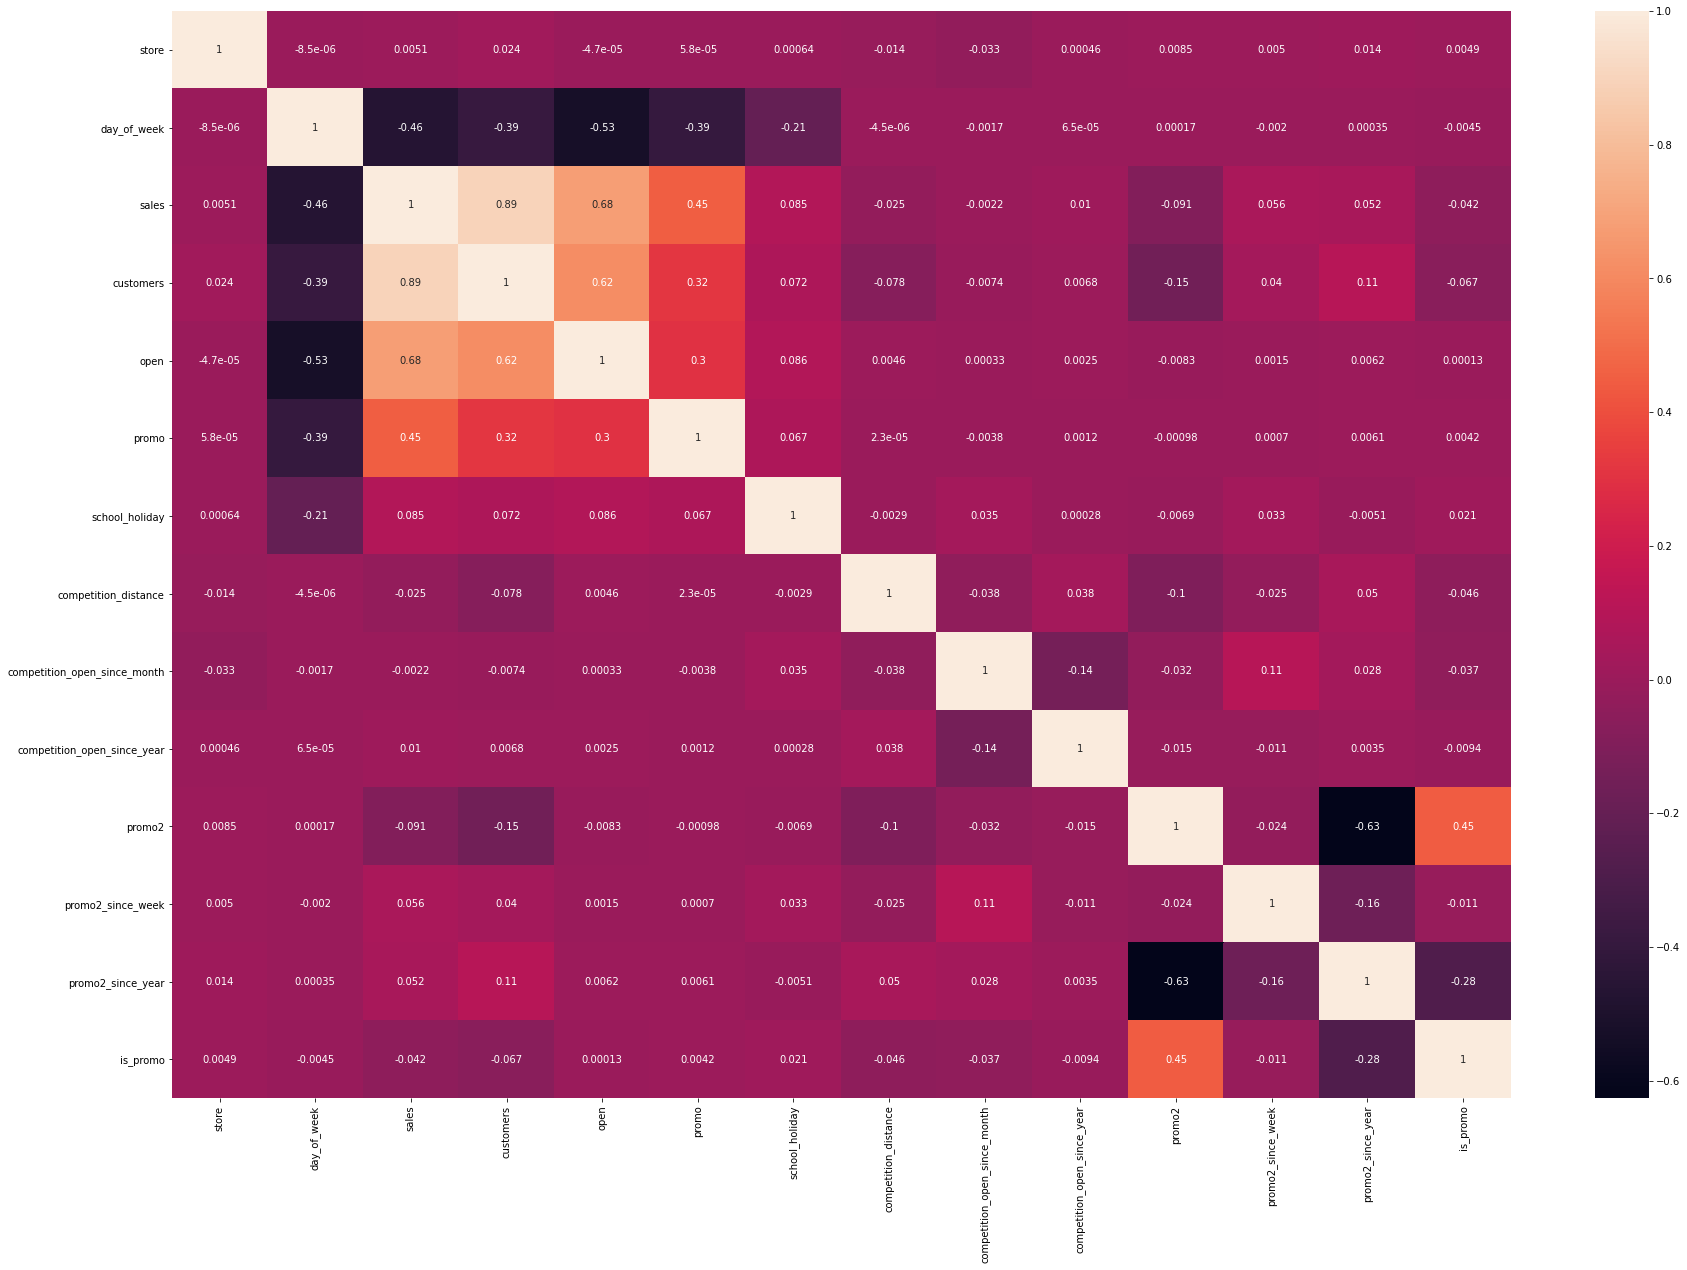

In [33]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

### Categorical Attributes

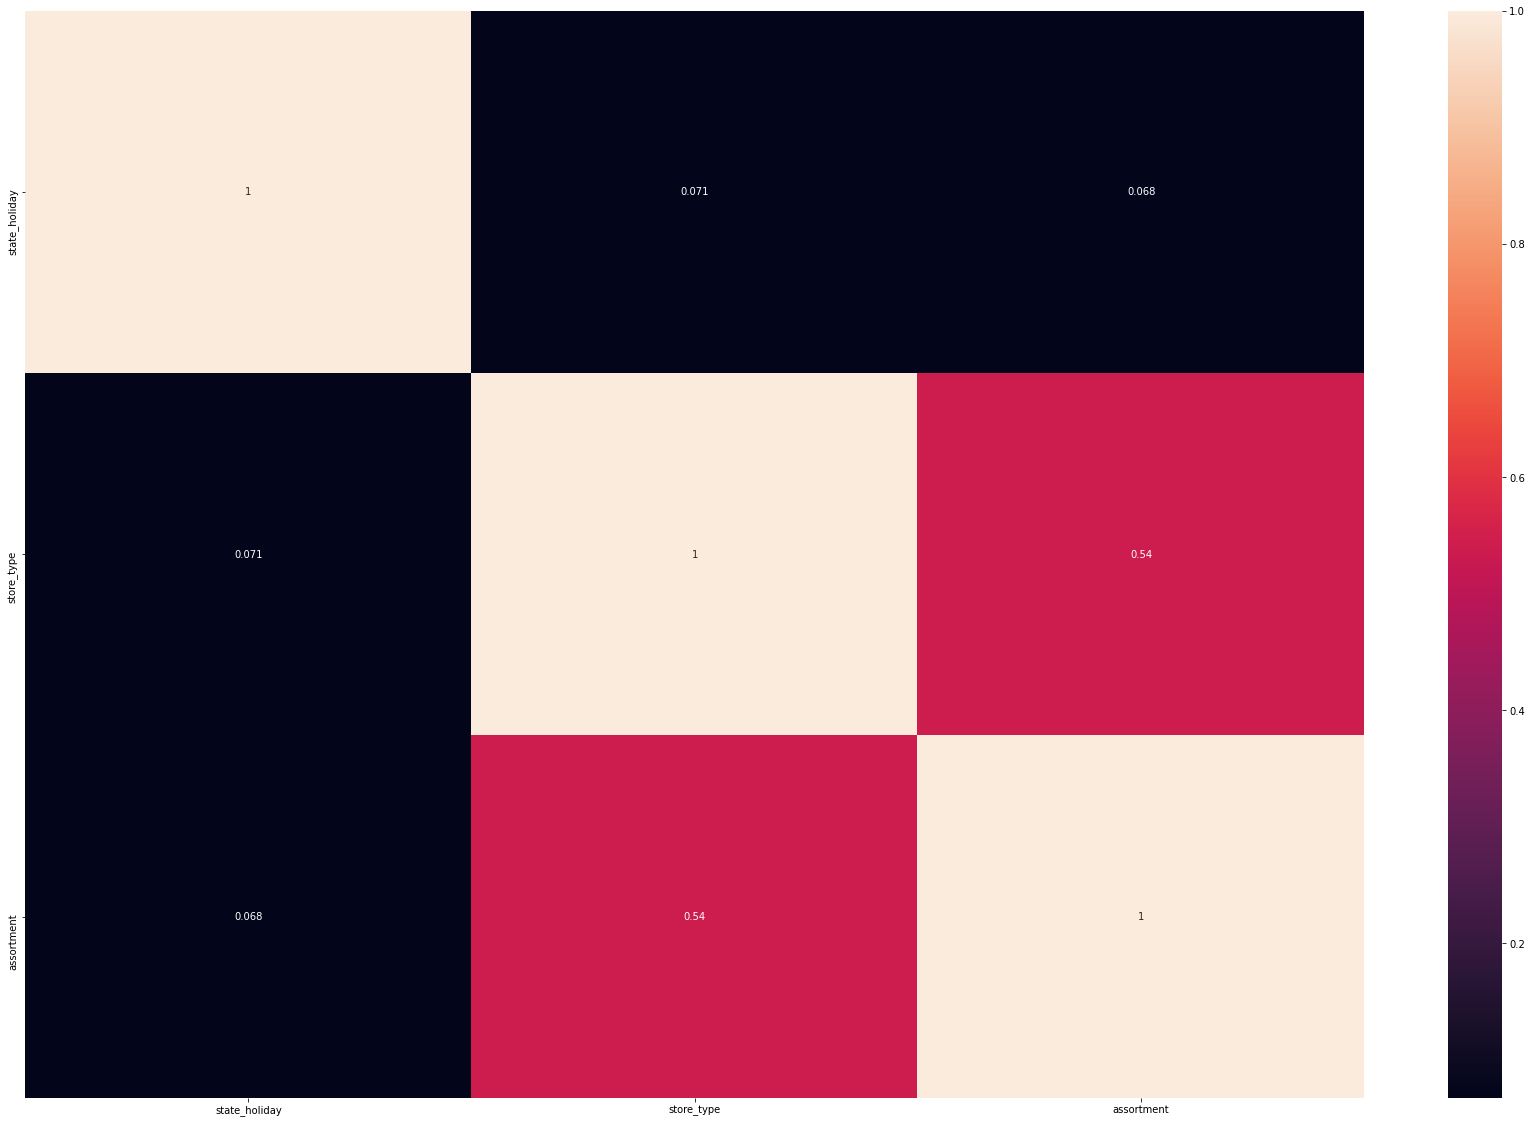

In [34]:
a = df4.select_dtypes(include='object')

a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3], 'store_type':[a4,a5,a6], 'assortment':[a7,a8,a9]})
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# Data Preparation

In [35]:
df5 = df4.copy()

## Normalization

## Rescaling

## Transformation